In [72]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys

In [73]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [74]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high    3. low  4. close  5. volume
date                                                                
2022-01-28 20:00:00   308.99    309.0  308.8700    308.87      725.0
2022-01-28 19:59:00   308.99    309.0  308.9899    309.00     1308.0


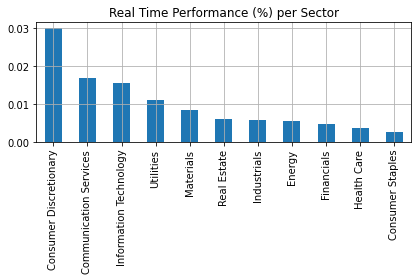

In [75]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [76]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [77]:
r = requests.get(url)
output = r.json()

In [78]:
print(output["Global Quote"]["05. price"])

134.5000


In [79]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.18,USD



In [80]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [81]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [82]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [83]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [84]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [85]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [86]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [87]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [88]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [89]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [90]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
129     DGRO
130     TD6C
131     TDG0
132    PTTRX
133      NaN
Name: Ticker, Length: 134, dtype: object

In [91]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [92]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb
28-Feb
02-Feb
01-Feb
11-Feb
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
16-Feb
16-Mar
04-Feb
16-Feb
27-Jan - UP (319.1700)
09-Feb
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
02-Feb
02-Feb
14-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb
22-Feb
09-Feb
09-Feb
28-Feb
23-Feb
15-Feb
15-Feb
26-Jan - UP (228.2200)
15-Feb
21-Feb
28-Feb
03-Feb
07-Feb
22-Feb
14-Feb
08-Feb
28-Feb
08-Feb
02-Feb
08-Feb
10-Feb
08-Mar
28-Mar
07-Mar
09-Mar
23-Feb
21-Mar
08-Mar
02-Mar
22-Feb
09-Feb
22-Feb
01-Feb
02-Feb
23-Feb
14-Feb
22-Feb
15-Mar
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb
09-Feb
21-Feb
01-Feb
18-Feb
01-Mar
02-Feb
21-Feb
01-Mar
22-Mar
14-Feb
22-Feb
23-Feb
23-Feb
08-Feb
09-Feb
22-Feb
23-Feb
03-Feb
09-Feb
16-Feb
27-Jan - UP (170.3300)
26-Jan - UP (528.6900)
22-Mar
17-Mar
23-Feb
31-Jan
03-Feb
10-Feb
23-Feb
08-Feb
28-Mar
10-Feb
22-Feb
02-Feb
14-Jan - DN (157.8900)
10-Feb
28-Feb
21-Feb
16-Feb
20-Jan - DN (269.5300)
18-Jan - DN (103.3400)


In [93]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [94]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [95]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [96]:
status = is_currentQtr(7)
print(status)

False


In [97]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [98]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [99]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter"]
    if any(word in title for word in words1) and any(word in title for word in words2):
        #print(True)
        return True
    return False

In [100]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [101]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [102]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [103]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [104]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [105]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [106]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [173]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE", "IS"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [108]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [109]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [155]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 27

FOR TABLE 0

TABLE DESCRIPTION:  
 CROWDSTRIKE REPORTS FISCAL FIRST QUARTER 2020 FINANCIAL RESULTS 

ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  · NaN  Total revenue of $96.1 million, grew 103% year...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
  · 
 
 
 
 TOTAL REVENUE OF $96.1 MILLION, GREW 103% YEAR-OVER-YEAR
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  · NaN  Subscription revenue of $86.0 million, grew 11...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
  · 
 
 
 
 SUBSCRIPTION REVENUE OF $86.0 MILLION,  GREW 116% YEAR-OVER-YEAR
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  · NaN  Record ARR of $364.6 million, grew 114% year-o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  
 FIRST QUARTER FISCAL 2020 FINAN

FINAL REPORT
                                   METRIC  \
4                         COST OF REVENUE   
5                     SALES AND MARKETING   
6                RESEARCH AND DEVELOPMENT   
7              GENERAL AND ADMINISTRATIVE   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
4                                             $368   
5                                             1518   
6                                              681   
7                                             1185   
8                                            $3752   

  THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  
4                                             $109  
5                                              773  
6                                              448  
7                                              389  
8                                            $1719  

FOR TABLE 20

TABLE DESCRIPTION:  
   

ORIGINAL TABLE  20
             

{1: [2], 4: [5]}

FINAL REPORT
                                            METRIC  \
3                        GAAP SUBSCRIPTION REVENUE   
5                   GAAP SUBSCRIPTION GROSS PROFIT   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8               NON-GAAP SUBSCRIPTION GROSS PROFIT   
10                  GAAP SUBSCRIPTION GROSS MARGIN   
12              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
3                                            $85990   
5                                            $62299   
6                                               270   
7                                               104   
8                                            $62673   
10                                              72%   
12                                              73%   

   THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  
3                                        

FINAL REPORT
                                               METRIC  \
4                                  GAAP TOTAL REVENUE   
6   GAAP NET CASH PROVIDED BY (USED IN) OPERATING ...   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
9                                      FREE CASH FLOW   
11  GAAP NET CASH PROVIDED BY (USED IN) INVESTING ...   
12  GAAP NET CASH PROVIDED BY (USED IN) FINANCING ...   
14  GAAP NET CASH PROVIDED BY (USED IN) OPERATING ...   
15  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
16  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
17                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
4                                            $96077   
6                                              1415   
7                                           (15541)   
8                                            (1984)   
9                          

In [110]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [111]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [112]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [113]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

Earning for stock UPST will be released later on 2022-03-15
None


In [114]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [151]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Earning for stock ABBV will be released later on 2022-02-02
Quote for stock ABBV on earning date 02-Feb not generated yet
Earning report for stock EPD on date 2022-02-01 does not exist, trying to fetch it
https://finance.yahoo.com/news/enterprise-reports-2021-results-110000426.html
TRYING TO STORE REFINED CONTENT IN FILE ../../Summary/Refined/EPD-2022-02-01_04-40-03.600788.txt
TRYING TO STORE TABLES IN FILE ../../Summary/report/EPD-REPORT-2022-02-01_04-40-03.600788.txt
NUMBER OF TABLES 22

FOR TABLE 0

TABLE DESCRIPTION: FOURTH QUARTER AND FULL YEAR 2021 FINANCIAL HIGHLIGHTS
ORIGINAL TABLE  0
                                             0  \
0                                          NaN   
1                                          NaN   
2     ($ in millions, except per unit amounts)   
3                             Operating income   
4                             

HEADERSSSSSSSSS ['0:4']
{3: [3], 9: [9]}

FINAL REPORT
                                               METRIC
5                                            REVENUES
6                                  COSTS AND EXPENSES
7                        OPERATING COSTS AND EXPENSES
8                    GENERAL AND ADMINISTRATIVE COSTS
9                            TOTAL COSTS AND EXPENSES
10      EQUITY IN INCOME OF UNCONSOLIDATED AFFILIATES
11                                   OPERATING INCOME
12                             OTHER INCOME (EXPENSE)
13                                   INTEREST EXPENSE
14                                         OTHER, NET
15                           TOTAL OTHER EXPENSE, NET
16                         INCOME BEFORE INCOME TAXES
17          BENEFIT FROM (PROVISION FOR) INCOME TAXES
18                                         NET INCOME
19  NET INCOME ATTRIBUTABLE TO NONCONTROLLING INTE...
20         NET INCOME ATTRIBUTABLE TO PREFERRED UNITS
21      NET INCOME ATTRIBUT

28                                              1708  

FOR TABLE 7

TABLE DESCRIPTION: 1,708
ORIGINAL TABLE  7
     0   1                                                  2
0  (1) NaN  Operating rates are reported on a net basis, w...
1  (2) NaN  Represents the NGL volumes we earn and take ti...
2  (3) NaN  Volumes reported correspond to the revenue str...
3  (4) NaN  Fee-based natural gas processing volumes are m...
4  (5) NaN  "BBtus/d" means billion British thermal units ...
5  (6) NaN  Reflects aggregate sales volumes for our octan...
6  (7) NaN  In addition to exports of refined products, th...
7  (8) NaN  Represents total NGL, crude oil, refined produ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 8

TABLE DESCRIPTION: REPRESENTS TOTAL NGL, CRUDE OIL, REFINED PRODUCTS AND PETROCHEMICAL TRANSPORTATION VOLUMES PLUS EQUIVALENT ENERGY VOLUMES WHERE 3.8 MILLION BRITISH THERMAL UNITS ("MMBTUS") OF NATURAL GAS TRANSPORTATION VOLUMES ARE EQUIVALENT TO ONE BARREL OF NGL


FINAL REPORT
                                               METRIC
5                              FREE CASH FLOW ("FCF")
6   NET CASH FLOW PROVIDED BY OPERATING ACTIVITIES...
7   ADJUSTMENTS TO RECONCILE NET CASH FLOW PROVIDE...
8                   CASH USED IN INVESTING ACTIVITIES
9    CASH CONTRIBUTIONS FROM NONCONTROLLING INTERESTS
10  CASH DISTRIBUTIONS PAID TO NONCONTROLLING INTE...
11                                     FCF (NON-GAAP)

FOR TABLE 13

TABLE DESCRIPTION: FCF IS A MEASURE OF HOW MUCH CASH A BUSINESS GENERATES AFTER ACCOUNTING FOR CAPITAL EXPENDITURES SUCH AS PLANTS OR PIPELINES. WE BELIEVE THAT FCF IS IMPORTANT TO TRADITIONAL INVESTORS SINCE IT REFLECTS THE AMOUNT OF CASH AVAILABLE FOR REDUCING DEBT, INVESTING IN ADDITIONAL CAPITAL PROJECTS AND/OR PAYING DISTRIBUTIONS. SINCE WE PARTNER WITH OTHER COMPANIES TO FUND CERTAIN CAPITAL PROJECTS OF OUR CONSOLIDATED SUBSIDIARIES, OUR DETERMINATION OF FCF APPROPRIATELY REFLECTS THE AMOUNT OF CASH CONTRIBUTED FROM AND DISTRIB

{3: [3]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 18

TABLE DESCRIPTION: <TD COLSPAN="1" ROWSPAN="1" STYLE="VERTICAL-ALIGN:BOTTOM;BORDER-BOTTOM:DOUBLE BLACK 2.25PT;PADDING-LEFT:0.0PX;PADDING-RIGHT:0.0PX;"></TD>
ORIGINAL TABLE  18
     0   1                                                  2
0  (1) NaN  Excludes amortization of major maintenance cos...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 19

TABLE DESCRIPTION: TOTAL GROSS OPERATING MARGIN EXCLUDES AMOUNTS ATTRIBUTABLE TO SHIPPER MAKE-UP RIGHTS AS DESCRIBED IN FOOTNOTE (5) TO EXHIBIT A OF THIS PRESS RELEASE.
ORIGINAL TABLE  19
                                          0  \
0         Enterprise Products Partners L.P.   
1             Other Information – UNAUDITED   
2                           ($ in millions)   
3                                       NaN   
4                                       NaN   
5                      Capital investments:   
6                      Capital expenditures   
7  Inve

FINAL REPORT
                                              METRIC
2  MARK-TO-MARKET GAINS (LOSSES) IN GROSS OPERATI...
3                           NGL PIPELINES & SERVICES
4                     CRUDE OIL PIPELINES & SERVICES
5                   NATURAL GAS PIPELINES & SERVICES
6          PETROCHEMICAL & REFINED PRODUCTS SERVICES
7  TOTAL MARK-TO-MARKET IMPACT ON GROSS OPERATING...

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                 Symbol  Last Price  Change % Change
0  EPDEnterprise Products Partners L.P.       23.64   -0.02   -0.08%
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND
Earning report for stock EPD fetching status True, filename EPD-2022-02-01_04-40-03.600788.txt
Earning report for stock EPD on date 2022-02-01 fetched, filename EPD-2022-02-01_04-40-03.600788.txt
Earning released for stock EPD PM
Get price diff for stock EPD from date 2022-02-01 and date 2022-01-31
Update Stock EPD with quote 01-Feb
Earning for stock ENB will be rele

https://finance.yahoo.com/news/entegris-reports-results-fourth-quarter-110000587.html
TRYING TO STORE REFINED CONTENT IN FILE ../../Summary/Refined/ENTG-2022-02-01_04-41-25.005435.txt
TRYING TO STORE TABLES IN FILE ../../Summary/report/ENTG-REPORT-2022-02-01_04-41-25.005435.txt
NUMBER OF TABLES 15

FOR TABLE 0

TABLE DESCRIPTION: STORY CONTINUES
ORIGINAL TABLE  0
                                                    0  \
0                 Quarterly Financial Results Summary   
1   (in thousands, except percentages and per shar...   
2                                        GAAP Results   
3                                           Net sales   
4                                    Operating income   
5              Operating margin - as a % of net sales   
6                                          Net income   
7                   Diluted earnings per common share   
8                                    Non-GAAP Results   
9                  Non-GAAP adjusted operating income   
10  Non

FINAL REPORT
                                            METRIC  \
7                                        NET SALES   
8                                    COST OF SALES   
9                                     GROSS PROFIT   
10    SELLING, GENERAL AND ADMINISTRATIVE EXPENSES   
11  ENGINEERING, RESEARCH AND DEVELOPMENT EXPENSES   
12               AMORTIZATION OF INTANGIBLE ASSETS   
13                                OPERATING INCOME   
14                           INTEREST EXPENSE, NET   
15                     OTHER EXPENSE (INCOME), NET   
16                INCOME BEFORE INCOME TAX EXPENSE   
17                              INCOME TAX EXPENSE   
18                                      NET INCOME   
21                 BASIC EARNINGS PER COMMON SHARE   
22               DILUTED EARNINGS PER COMMON SHARE   
24             WEIGHTED AVERAGE SHARES OUTSTANDING   
25                                           BASIC   
26                                         DILUTED   

   NAN THREE M

{}

FINAL REPORT
                                               METRIC  \
7                                OPERATING ACTIVITIES   
8                                          NET INCOME   
9   ADJUSTMENTS TO RECONCILE NET INCOME TO NET CAS...   
10                                       DEPRECIATION   
11                                       AMORTIZATION   
12                   STOCK-BASED COMPENSATION EXPENSE   
13    LOSS ON EXTINGUISHMENT OF DEBT AND MODIFICATION   
14                                              OTHER   
15  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
16                TRADE ACCOUNTS AND NOTES RECEIVABLE   
17                                        INVENTORIES   
18           ACCOUNTS PAYABLE AND ACCRUED LIABILITIES   
19  INCOME TAXES PAYABLE, REFUNDABLE INCOME TAXES ...   
20                                              OTHER   
21          NET CASH PROVIDED BY OPERATING ACTIVITIES   
22                               INVESTING ACTIVITIES   
23            

FINAL REPORT
                                         METRIC  \
2  SPECIALTY CHEMICALS AND ENGINEERED MATERIALS   
3                    MICROCONTAMINATION CONTROL   
4                   ADVANCED MATERIALS HANDLING   
5                          TOTAL SEGMENT PROFIT   
6                   AMORTIZATION OF INTANGIBLES   
7                          UNALLOCATED EXPENSES   
8                        TOTAL OPERATING INCOME   

  THREE MONTHS ENDED DECEMBER 31, 2021 THREE MONTHS ENDED DECEMBER 31, 2020  \
2                               $47215                               $29761   
3                                94203                                71691   
4                                45304                                34321   
5                               186722                               135773   
6                                12240                                11916   
7                                14938                                10629   
8                        

FOR TABLE 9

TABLE DESCRIPTION: $395,445
ORIGINAL TABLE  9
                                                    0                   1  \
0                                                 NaN  Three months ended   
1                             Adjusted segment profit   December 31, 2021   
2                                 SCEM segment profit             $47,215   
3                                   Integration costs                   —   
4                   Severance and restructuring costs                   —   
5   Charge for fair value write-up of acquired inv...                 428   
6                        SCEM adjusted segment profit             $47,643   
7                                                 NaN                 NaN   
8                                   MC segment profit             $94,203   
9                   Severance and restructuring costs                   —   
10  Charge for fair value write-up of acquired inv...                   —   
11               

21  1The tax effect of pre-tax adjustments to net ...  
HEADERSSSSSSSSS ['0:5']
{}

FINAL REPORT
                                               METRIC  \
7                                     GAAP NET INCOME   
8                           ADJUSTMENTS TO NET INCOME   
9   CHARGE FOR FAIR VALUE WRITE-UP OF INVENTORY AC...   
10                         DEAL AND TRANSACTION COSTS   
11                                  INTEGRATION COSTS   
12                  SEVERANCE AND RESTRUCTURING COSTS   
13    LOSS ON EXTINGUISHMENT OF DEBT AND MODIFICATION   
14                  AMORTIZATION OF INTANGIBLE ASSETS   
15  TAX EFFECT OF ADJUSTMENTS TO NET INCOME AND DI...   
16                                NON-GAAP NET INCOME   
18                  DILUTED EARNINGS PER COMMON SHARE   
19                EFFECT OF ADJUSTMENTS TO NET INCOME   
20         DILUTED NON-GAAP EARNINGS PER COMMON SHARE   
21  THE TAX EFFECT OF PRE-TAX ADJUSTMENTS TO NET I...   

   NAN THREE MONTHS ENDED DECEMBER 31, 2021  \


Earning report for stock ENTG fetching status True, filename ENTG-2022-02-01_04-41-25.005435.txt
Earning report for stock ENTG on date 2022-02-01 fetched, filename ENTG-2022-02-01_04-41-25.005435.txt
Earning released for stock ENTG PM
Get price diff for stock ENTG from date 2022-02-01 and date 2022-01-31
Update Stock ENTG with quote 01-Feb
Earning for stock DKNG will be released later on 2022-02-18
Quote for stock DKNG on earning date 18-Feb not generated yet
Earning for stock DPZ will be released later on 2022-03-01
Quote for stock DPZ on earning date 01-Mar not generated yet
Earning for stock FB will be released later on 2022-02-02
Quote for stock FB on earning date 02-Feb not generated yet
Earning for stock PUBM will be released later on 2022-02-21
Quote for stock PUBM on earning date 21-Feb not generated yet
Earning for stock OKTA will be released later on 2022-03-01
Quote for stock OKTA on earning date 01-Mar not generated yet
Earning for stock RH will be released later on 2022-03

In [117]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [121]:
stocks = get_earningDates(d, "WK")
print(stocks, "\n", len(stocks))

[['ABBV', '02-Feb-2022'], ['EPD', '01-Feb-2022'], ['BMY', '04-Feb-2022'], ['PYPL', '02-Feb-2022'], ['PINS', '03-Feb-2022'], ['WD', '03-Feb-2022'], ['MTCH', '01-Feb-2022'], ['QRVO', '02-Feb-2022'], ['ENTG', '01-Feb-2022'], ['FB', '02-Feb-2022'], ['SNAP', '03-Feb-2022'], ['BABA', '31-Jan-2022'], ['AMZN', '03-Feb-2022'], ['IDXX', '02-Feb-2022']] 
 14


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [123]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [124]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [125]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [126]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [127]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [128]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [129]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [130]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [131]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [132]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [133]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [166]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [135]:
def isBold(tag, ctext):
    if(tag.name == "b" or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [136]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tag))
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [137]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [138]:
def isPadLeft(item):
    if(item.name == "ul"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
    return False

In [139]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [140]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    if not txt:
        ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name != "ul" and item.parent.name != "ul"):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
    
    return(possibleTblTitle)

In [141]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [142]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            print(ndata)
            #print(" ".join(ndata))
            #print("\n")
            f.write("PG*** "+" ".join(ndata))
            f.write("\n")
            #print(item.name, " ".join(ndata))
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [143]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            continue
        nanCnt = 0
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                replc = ["NON-GAAP", "NON GAAP", "GAAP"]
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        break
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met and "PER SHARE" not in met and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met or "EPS" in met)):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
            else:
                header = header + " " + met
        elif(met == "TOTAL"):
            header = None
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [144]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul"):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [187]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2021-06-03"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [184]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000011/crwd-20210603xex991.htm"
source = getPgSource(url)

In [185]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 16

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                      Total revenue   
3                    Non-GAAP income from operations   
4    Non-GAAP net income attributable to CrowdStrike   
5  Non-GAAP net income per share attributable to ...   
6  Weighted average shares used in computing non-...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                      Total revenue   
3                    Non-GAAP income from operations   
4    Non-GAAP net income attributable to CrowdStrike   
5  Non-GAAP net income per share attributable to ...   
6  Weighted average shares used in computing non-...   

                             

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                       SUBSCRIPTION    
9                              PROFESSIONAL SERVICES    
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                               SALES AND MARKETING    
14                          RESEARCH AND DEVELOPMENT    
15                        GENERAL AND ADMINISTRATIVE    
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   
18 

FINAL REPORT
                                        METRIC  \
5                 SUBSCRIPTION COST OF REVENUE   
6                          SALES AND MARKETING   
7                     RESEARCH AND DEVELOPMENT   
8  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5                                            $1995   
6                                              422   
7                                              nan   
8                                            $2417   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  
5                                              $62  
6                                               31  
7                                               10  
8                                             $103  

FOR TABLE 5

TABLE DESCRIPTION:  (3) INCLUDES ACQUISITION-RELATED EXPENSES AS FOLLOWS:
ORIGINAL TABLE  5
                                   0                                   1   \
0                

6                                                $  

FOR TABLE 7

TABLE DESCRIPTION:  
ORIGINAL TABLE  7
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                      Other income, net   
6  Total gain from strategic investments   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                      Other income, net   
6  Total gain from strategic investments   

                                      2                             3   \
0                                    NaN                           NaN   
1                                    NaN

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                    LOSS ON DISPOSAL OF FIXED ASSETS   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                     NON-CASH OPERATING LEASE COSTS   
11                            PROVISION FOR BAD DEBTS   
12                   STOCK-BASED COMPENSATION EXPENSE   
13               GAIN ON SALE OF DEBT SECURITIES, NET   
14  ACCRETION OF MARKETABLE SECURITIES PURCHASED A...   
15                          NON-CASH INTEREST EXPENSE   
16      CHANGE IN FAIR VALUE OF STRATEGIC INVESTMENTS   
17        CHANGES IN OPERATING ASSETS AND LIABILITIES   
18 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                            METRIC  \
3                               GAAP TOTAL REVENUE   
5                        GAAP LOSS FROM OPERATIONS   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                 ADD ACQUISITION-RELATED EXPENSES   
9                  NON-GAAP INCOME FROM OPERATIONS   
11                           GAAP OPERATING MARGIN   
13                       NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDED APRIL 30, 2021 THREE MONTHS ENDED APRIL 30, 2020  
3                            $302843                           $178078  
5                           $(31347)                          $(22576)  
6                              54362                             23638  
7                               2417                               103  
8                               4345                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                  GAAP TOTAL REVENUE   
5      GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7   LESS CAPITALIZED INTERNAL-USE SOFTWARE AND WEB...   
8                                      FREE CASH FLOW   
10  GAAP NET CASH (USED IN) PROVIDED BY INVESTING ...   
11     GAAP NET CASH PROVIDED BY FINANCING ACTIVITIES   
13  GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES...   
14  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
15  LESS CAPITALIZED INTERNAL-USE SOFTWARE AND WEB...   
16                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED APRIL 30, 2021 THREE MONTHS ENDED APRIL 30, 2020  
3                            $302843                           $178078  
5                             147533                             98577  
6                            (25796

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3           GAAP NET LOSS ATTRIBUTABLE TO CROWDSTRIKE   
4                                                 ADD   
5                    STOCK BASED COMPENSATION EXPENSE   
6          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                        ACQUISITION-RELATED EXPENSES   
8    AMORTIZATION OF DEBT ISSUANCE COSTS AND DISCOUNT   
9                          PROVISION FOR INCOME TAXES   
10                                               LESS   
11  GAIN ON STRATEGIC INVESTMENTS ATTRIBUTABLE TO ...   
12    NON-GAAP NET INCOME ATTRIBUTABLE TO CROWDSTRIKE   
14  WEIGHTED-AVERAGE SHARES USED IN COMPUTING BASI...   
16  GAAP BASIC NET LOSS PER SHARE ATTRIBUTABLE TO ...   
18  NON-GAAP BASIC NET INCOME PER SHARE ATTRIBUTAB...   
20  GAAP DILUTED NET LOSS PER SHARE ATTRIBUTABLE T...   
21                                                ADD   
22                         

In [186]:
allTables

{'TOTAL': 16,
 'PARSESUCCESS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'PARSEFAIL': [],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":null,"1":null,"2":null,"3":"Q2 FY22Guidance","4":"Q2 FY22Guidance","5":"Q2 FY22Guidance","6":null,"7":null,"8":null,"9":"Full Year FY22Guidance","10":"Full Year FY22Guidance","11":"Full Year FY22Guidance"},{"0":"Total revenue","1":"Total revenue","2":"Total revenue","3":"$318.3 - $324.4 million","4":"$318.3 - $324.4 million","5":"$318.3 - $324.4 million","6":null,"7":null,"8":null,"9":"$1,347.0 - $1,365.7 million","10":"$1,347.0 - $1,365.7 million","11":"$1,347.0 - $1,365.7 million"},{"0":"Non-GAAP income from operations","1":"Non-GAAP income from operations","2":"Non-GAAP income from operations","3":"$26.3 - $30.7 million","4":"$26.3 - $30.7 million","5":"$26.3 - $30.7 million","6":null,"7":null,"8":null,"9":"$115.7- $129.6 million","10":"$115.7- $

In [188]:
csym = "CRWD"
#rptDest = "../../Summary/EDGAR/8-K/"+csym
#textFilename = rptDest+"/ADBE_2021-12-16_EP.txt"
#testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
testOne8KEdgarRpt(url, csym, None, source, allTables)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/CRWD'
NOPAD*** Document.


SC*** CrowdStrike Reports First Quarter Fiscal Year 2022 Financial Results.


SC*** SUNNYVALE, Calif., June 3, 2021 -- CrowdStrike Holdings, Inc. (Nasdaq: CRWD), a leader in cloud-delivered endpoint and cloud workload protection, today announced financial results for the first quarter fiscal year 2022, ended April 30, 2021.

NOPAD*** “CrowdStrike kicked off the new fiscal year with strong momentum and delivered outstanding first quarter results that exceeded our expectations. We saw strength in multiple areas of the business, added $144 million in net new ARR in the quarter and grew ending ARR 74% year-over-year to exceed $1.19 billion. The CrowdStrike name has become synonymous with best-in-class cybersecurity protection and a platform that just works. Customers of all sizes are increasingly choosing CrowdStrike as their security platform of record with 1,524 net new 

In [189]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [190]:
csym = "CRWD"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/CRWD'
1535527
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-19-035685-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-19-035685-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001558370-19-006148-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm
NUMBER OF TABLES 27

FOR TABLE 0

TABLE DESCRIPTION:  
 CROWDSTRIKE REPORTS FISCAL FIRST QUARTER 2020 FINANCIAL RESULTS 

ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  · NaN  Total revenue of $96.1 million, grew 103% year...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
  · 
 
 
 
 TOTAL REVENUE OF $96.1 MILLION, GREW 103% YEAR-OVER-YEAR
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  · Na

FINAL REPORT
                                               METRIC  \
2                                             REVENUE   
3                                        SUBSCRIPTION   
4                               PROFESSIONAL SERVICES   
5                                       TOTAL REVENUE   
7                                    COST OF REVENUE    
8                                        SUBSCRIPTION   
9                               PROFESSIONAL SERVICES   
10                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
14                                 OPERATING EXPENSES   
15                               SALES AND MARKETING    
16                          RESEARCH AND DEVELOPMENT    
17                        GENERAL AND ADMINISTRATIVE    
18                           TOTAL OPERATING EXPENSES   
20                               LOSS FROM OPERATIONS   
21                                   INTEREST EXPENSE   
22                

FINAL REPORT
                                            METRIC  \
4                               GAAP TOTAL REVENUE   
6                        GAAP LOSS FROM OPERATIONS   
7             ADD STOCK-BASED COMPENSATION EXPENSE   
8   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9                    NON-GAAP LOSS FROM OPERATIONS   
11                           GAAP OPERATING MARGIN   
13                       NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  \
4                                            $96077   
6                                          $(25775)   
7                                              3752   
8                                               146   
9                                          $(21877)   
11                                            (27)%   
13                                            (23)%   

   THREE MONTHS ENDED APRIL 30, 2018 (IN THOUSANDS)  
4                                            $47289  
6    

NOPAD*** crwd_Ex99_1.


SC*** Exhibit 99.1.


SC*** CrowdStrike Reports Fiscal First Quarter 2020 Financial Results.

TABLEEEEEEEEEEE 0
['·', 'Total revenue of $96.1 million, grew 103% year - over - year']
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
['·', 'Subscription revenue of $86.0 million,  grew 116% year - over - year']
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
['·', 'Record ARR of $364.6 million, grew 114% year - over - year']
TABLEEEE CNTTTTT 3

SC*** Sunnyvale, California – July 18, 2019 – GlobeNewswire, CrowdStrike Holdings, Inc., (Nasdaq: CRWD), a leader in cloud-delivered endpoint protection, today announced financial results for the first quarter of its fiscal 2020, ended April 30, 2019.

NOPAD*** “We are pleased with the strong start to the year. We achieved 103% year-over-year revenue growth in the first quarter, which is consistent with the preliminary results that we shared in our IPO prospectus. As the pioneer of cloud native endpoint security, CrowdStrike provides the only endpo

10                       3943  
HEADERSSSSSSSSS ['0:2']
{1: [2], 4: [5], 6: [7], 9: [10]}

FINAL REPORT
                                    METRIC  \
5             SUBSCRIPTION COST OF REVENUE   
6    PROFESSIONAL SERVICES COST OF REVENUE   
7                      SALES AND MARKETING   
8                 RESEARCH AND DEVELOPMENT   
9               GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   THREE MONTHS ENDED JULY 31, 2019 (IN THOUSANDS)  \
5                                            $1233   
6                                              644   
7                                             6638   
8                                             4976   
9                                            16368   
10                                          $29859   

   THREE MONTHS ENDED JULY 31, 2018 (IN THOUSANDS)  \
5                                              $88   
6                                               57   
7                               

{1: [2], 4: [5], 7: [8], 10: [11]}

FINAL REPORT
                                            METRIC  \
5                               GAAP TOTAL REVENUE   
7                        GAAP LOSS FROM OPERATIONS   
8             ADD STOCK-BASED COMPENSATION EXPENSE   
9   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
10                   NON-GAAP LOSS FROM OPERATIONS   
12                           GAAP OPERATING MARGIN   
14                       NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDED JULY 31, 2019 (IN THOUSANDS)  \
5                                          $108108   
7                                         $(50639)   
8                                            29859   
9                                              139   
10                                        $(20641)   
12                                           (47)%   
14                                           (19)%   

   THREE MONTHS ENDED JULY 31, 2018 (IN THOUSANDS)  \
5                              

{1: [2], 4: [5], 6: [7], 9: [10]}

FINAL REPORT
                                               METRIC  \
5                                GAAP COST OF REVENUE   
6                                                LESS   
7                    STOCK BASED COMPENSATION EXPENSE   
8          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9                            NON-GAAP COST OF REVENUE   
11                     GAAP SUBSCRIPTION GROSS PROFIT   
12                                                ADD   
13                   STOCK BASED COMPENSATION EXPENSE   
14         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
15                 NON-GAAP SUBSCRIPTION GROSS PROFIT   
17            GAAP PROFESSIONAL SERVICES GROSS PROFIT   
18                                                ADD   
19                   STOCK BASED COMPENSATION EXPENSE   
20        NON-GAAP PROFESSIONAL SERVICES GROSS PROFIT   
22        GAAP SALES AND MARKETING OPERATING EXPENSES   
23                                      

NOPAD*** crwd_Ex99_1.


SC*** Exhibit 99.1.


SC*** CrowdStrike Reports Fiscal Second Quarter 2020 Financial Results.

TABLEEEEEEEEEEE 0
['·', 'Total revenue of $108.1 million, grew 94% year - over - year']
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
['·', 'Subscription revenue of $97.6 million, grew 98% year - over - year']
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
['·', 'ARR of $423.8 million, grew 104% year - over - year']
TABLEEEE CNTTTTT 3

SC*** SUNNYVALE, Calif., September 5, 2019 -- CrowdStrike Holdings, Inc., (Nasdaq: CRWD), a leader in cloud-delivered endpoint protection, today announced financial results for the second quarter of its fiscal 2020, ended July 31, 2019.

NOPAD*** “We delivered a strong second quarter with rapid subscription revenue growth and record net new ARR generated in the quarter,” said George Kurtz, CrowdStrike’s co-founder and chief executive officer. “Customer growth accelerated as an increasing number of organizations recognize the power of CrowdStrike’s cloud-na


FINAL REPORT
                                              METRIC  \
2                                      TOTAL REVENUE   
3                      NON-GAAP LOSS FROM OPERATIONS   
4                                  NON-GAAP NET LOSS   
5     NON-GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
6  WEIGHTED AVERAGE SHARES USED IN COMPUTING NON-...   

            Q4 FY20GUIDANCE    FULL YEAR FY20GUIDANCE  
2   $135.9  $ 138.6 million  $ 465.2  $ 468.0 million  
3  $(21.6)  $(19.7) million  $(80.5)  $(78.6) million  
4  $(19.1)  $(17.2) million  $(77.7)  $(75.8) million  
5          $(0.09)  $(0.08)          $(0.53)  $(0.52)  
6             205.2 million             146.7 million  

FOR TABLE 1

TABLE DESCRIPTION:  
ORIGINAL TABLE  1
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3  Dial-in number:  Dial-in number: 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                              $1666   
5                                                784   
6                                               7355   
7                                               4696   
8                                               7465   
9                                             $21966   

  THREE MONTHS ENDED OCTOBER 31, 2018 (IN THOUSANDS)  \
4                                               $382   
5                                                 53   
6                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
3                        GAAP SUBSCRIPTION REVENUE   
5                   GAAP SUBSCRIPTION GROSS PROFIT   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8               NON-GAAP SUBSCRIPTION GROSS PROFIT   
10                  GAAP SUBSCRIPTION GROSS MARGIN   
12              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2019 THREE MONTHS ENDED OCTOBER 31, 2018  \
3                              $114221                              $57651   
5                               $85000                              $40349   
6                                 1666                                 382   
7                                   61                                  20   
8                               $86727                              $40751


FINAL REPORT
                                               METRIC  \
3                                       GAAP NET LOSS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6      ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  LESS GAIN ON SETTLEMENT OF LAWSUIT   
9                                   NON-GAAP NET LOSS   
11  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
13  GAAP NET LOSS PER SHARE ATTRIBUTABLE TO COMMON...   
15  NON- GAAP NET LOSS PER SHARE ATTRIBUTABLE TO C...   

   THREE MONTHS ENDED OCTOBER 31, 2019 THREE MONTHS ENDED OCTOBER 31, 2018  \
3                             $(35505)                            $(42323)   
5                               $21966                              $13460   
6                                  101                                  62   
7                                  nan                                 nan   
9                             $(13438)                            $(28801)   
11  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                GAAP COST OF REVENUE   
5                                                LESS   
6                    STOCK BASED COMPENSATION EXPENSE   
7          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                            NON-GAAP COST OF REVENUE   
10                     GAAP SUBSCRIPTION GROSS PROFIT   
11                                                ADD   
12                   STOCK BASED COMPENSATION EXPENSE   
13         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
14                 NON-GAAP SUBSCRIPTION GROSS PROFIT   
16            GAAP PROFESSIONAL SERVICES GROSS PROFIT   
17                                                ADD   
18                   STOCK BASED COMPENSATION EXPENSE   
19        NON-GAAP PROFESSIONAL SERVICES GROSS PROFIT   
21        GAAP SALES AND MARKETING OPERATI

NOPAD*** Document.


SC*** Exhibit 99.1.

NOPAD*** Surpasses $500 million in ARR and achieves positive cash flow from operations and free cash flow.

NOPAD*** Increases full year revenue outlook.


SC*** SUNNYVALE, Calif., December 5, 2019 -- CrowdStrike Holdings, Inc., (Nasdaq: CRWD), a leader in cloud-delivered endpoint protection, today announced financial results for the third quarter of its fiscal 2020, ended October 31, 2019.

NOPAD*** “Third quarter results well exceeded our expectations and CrowdStrike delivered the best quarter yet in company history with strength in multiple areas of the business including 98% subscription revenue growth and record net new ARR. We achieved two significant milestones as ARR grew 97% year-over-year to exceed half a billion dollars and we generated positive cash flow in the quarter,” said George Kurtz, CrowdStrike’s co-founder and chief executive officer.

NOPAD*** “Strong demand among organizations across diverse sizes and industries and our fr

FOR TABLE 1

TABLE DESCRIPTION:  
ORIGINAL TABLE  1
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3  Dial-in number:  Dial-in number:  Dial-in number:   
4         Webcast:         Webcast:         Webcast:   

                                                 3  \
0                                              NaN   
1                                   March 19, 2020   
2  2:00 p.m. Pacific time / 5:00 p.m. Eastern time   
3             409-937-8967, conference ID: 5282383   
4                               ir.crowdstrike.com   

                                                 4  \
0                                              NaN   
1                                   March 19, 2020   
2  2:00 p.m. Pacific time / 5:00 p.m. Eastern time   
3             409-937-8967, conference ID: 5282383   
4               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
4                                              $2062   
5                                                955   
6                                               8408   
7                                               5050   
8                                               7888   
9                                             $24363   

  THREE MONTHS ENDED JANUARY 31, 2019 (IN THOUSANDS)  \
4                                               $156   
5                                                 49   
6                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                    LOSS ON DISPOSAL OF FIXED ASSETS   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
11                            PROVISION FOR BAD DEBTS   
12                   STOCK-BASED COMPENSATION EXPENSE   
13  ACCRETION OF MARKETABLE SECURITIES PURCHASED A...   
14                          NON-CASH INTEREST EXPENSE   
15                             OTHER NON-CASH CHARGES   
16  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
17                                ACCOUNTS RECEIVABLE   
18                DEFERRED 

FOR TABLE 9

TABLE DESCRIPTION:  
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                       GAAP net loss   
4                                                 NaN   
5               Add: Stock-based compensation expense   
6     Add: Amortization of acquired intangible assets   
7                 Less: Gain on settlement of lawsuit   
8                                                 NaN   
9                                   Non-GAAP net loss   
10                                                NaN   
11  Weighted-average shares used in computing net ...   
12                                                NaN   
13  GAAP net loss per share attributable to Class ...   
14                                                NaN   
15  Non- GAAP net loss per share att

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                GAAP COST OF REVENUE   
5                                                LESS   
6                    STOCK BASED COMPENSATION EXPENSE   
7          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                            NON-GAAP COST OF REVENUE   
10                     GAAP SUBSCRIPTION GROSS PROFIT   
11                                                ADD   
12                   STOCK BASED COMPENSATION EXPENSE   
13         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
14                 NON-GAAP SUBSCRIPTION GROSS PROFIT   
16            GAAP PROFESSIONAL SERVICES GROSS PROFIT   
17                                                ADD   
18                   STOCK BASED COMPENSATION EXPENSE   
19        NON-GAAP PROFESSIONAL SERVICES GROSS PROFIT   
21        GAAP SAL

NOPAD*** Document.


SC*** CrowdStrike Reports Fourth Quarter and Fiscal Year 2020 Financial Results.

NOPAD*** Achieves $600 million in ARR.

NOPAD*** Delivers positive cash flow from operations and free cash flow for the quarter and year.


SC*** SUNNYVALE, Calif., March 19, 2020 -- CrowdStrike Holdings, Inc., (Nasdaq: CRWD), a leader in cloud-delivered endpoint protection, today announced financial results for the fourth quarter and fiscal year 2020 ended January 31, 2020.

NOPAD*** “CrowdStrike delivered a record-setting fourth quarter to conclude an exceptional fiscal year. With ARR reaching $600 million, we continued to see broad strength in multiple areas of the business during the quarter, including 90% year-over-year subscription revenue growth, record net new ARR and an acceleration in net new customers. Throughout this past year, we continued to execute on the increasing demand we see in the market and the Security Cloud vision we pioneered. Looking into fiscal 2021 and beyo

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  \
4                                            $1995   
5                                              971   
6                                             8687   
7                                             4900   
8                                             7085   
9                                           $23638   

  THREE MONTHS ENDED APRIL 30, 2019 (IN THOUSANDS)  
4                                             $265  
5                                              103  
6                                             1518  
7                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                     NON-CASH OPERATING LEASE COSTS   
11  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
12                            PROVISION FOR BAD DEBTS   
13                   STOCK-BASED COMPENSATION EXPENSE   
14               GAIN ON SALE OF DEBT SECURITIES, NET   
15  AMORTIZATION (ACCRETION) OF MARKETABLE SECURIT...   
16                          NON-CASH INTEREST EXPENSE   
17        CHANGES IN OPERATING ASSETS AND LIABILITIES   
18                                ACCOUNTS RECEIVABLE   
19                DEFERRED 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                  GAAP TOTAL REVENUE   
5      GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
8                                      FREE CASH FLOW   
10         GAAP NET CASH USED IN INVESTING ACTIVITIES   
11  GAAP NET CASH PROVIDED BY (USED IN) FINANCING ...   
13  GAAP NET CASH USED IN OPERATING ACTIVITIES AS ...   
14  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
15  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
16                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED APRIL 30, 2020 THREE MONTHS ENDED APRIL 30, 2019  
3                            $178078                            $96077  
5                              98577                              1415  
6          

NOPAD*** Document.


SC*** CrowdStrike Reports Fiscal First Quarter 2021 Financial Results.

NOPAD*** Achieves $686 million in ARR, 89% year-over-year subscription revenue growth, and record operating and free cash flow.


SC*** SUNNYVALE, Calif., June 2, 2020 -- CrowdStrike Holdings, Inc., (Nasdaq: CRWD), a leader in cloud-delivered endpoint protection, today announced financial results for the first quarter of its fiscal 2021, ended April 30, 2020.

NOPAD*** “CrowdStrike finished the quarter with strong momentum and delivered results that exceeded our expectations across the board,” said George Kurtz, CrowdStrike’s co-founder and chief executive officer. "An increasing number of organizations recognize the power of CrowdStrike’s cloud-native Falcon platform to effectively stop breaches as well as simplify their security and I.T. operations stack with a single, lightweight agent. Cybersecurity is mission critical and in the quarter our customers continued to prioritize their cybersecu

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                              METRIC          Q3 FY21GUIDANCE  \
2                                      TOTAL REVENUE  $210.6 - $215.0 million   
3             NON-GAAP INCOME (LOSS) FROM OPERATIONS    $(1.4) - $1.6 million   
4                         NON-GAAP NET INCOME (LOSS)    $(2.2) - $0.9 million   
5      NON-GAAP NET INCOME (LOSS) PER SHARE, DILUTED          $(0.01) - $0.00   
7  WEIGHTED AVERAGE SHARES USED IN COMPUTING NON-...              219 million   
8  WEIGHTED AVERAGE SHARES USED IN COMPUTING NON-...              235 million   

    FULL YEAR FY21GUIDANCE  
2  $809.1 - $826.7 million  
3     $3.6 - $16.4 million  
4     $5.6 - $18.4 million  
5            $0.02 - $0.08  
7              218 million  
8              234 million  

FOR TABLE 1

TABLE DESCRIPTION:  CROWDSTRIKE WILL HOST A CONFERENCE CALL FOR ANALYSTS AND INVESTORS TO DISCUSS ITS EARNINGS RESULTS FOR THE SECOND QUARTER OF FISCAL 2021 AND OUTLOO

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                       SUBSCRIPTION    
9                              PROFESSIONAL SERVICES    
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                               SALES AND MARKETING    
14                          RESEARCH AND DEVELOPMENT    
15                        GENERAL AND ADMINISTRATIVE    
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   
18                                   INTEREST EXPENSE   
19                

FINAL REPORT
                                        METRIC  \
4                 SUBSCRIPTION COST OF REVENUE   
5                          SALES AND MARKETING   
6                     RESEARCH AND DEVELOPMENT   
7  TOTAL AMORTIZATION OF PURCHASED INTANGIBLES   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4                                             $63   
5                                              31   
6                                              10   
7                                            $104   

  THREE MONTHS ENDED JULY 31, 2019 (IN THOUSANDS)  \
4                                             $97   
5                                              32   
6                                              10   
7                                            $139   

  SIX MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
4                                          $125   
5                                            62   
6                                            20   



FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                      NON-CASH OPERATING LEASE COST   
11  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
12                            PROVISION FOR BAD DEBTS   
13                   STOCK-BASED COMPENSATION EXPENSE   
14               GAIN ON SALE OF DEBT SECURITIES, NET   
15  ACCRETION (AMORTIZATION) OF MARKETABLE SECURIT...   
16                          NON-CASH INTEREST EXPENSE   
17        CHANGES IN OPERATING ASSETS AND LIABILITIES   
18                                ACCOUNTS RECEIVABLE   
19                DEFERRED CONTRACT ACQUISITION COSTS   
20               

FINAL REPORT
                                            METRIC  \
3                               GAAP TOTAL REVENUE   
5                        GAAP LOSS FROM OPERATIONS   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8           NON-GAAP INCOME (LOSS) FROM OPERATIONS   
10                           GAAP OPERATING MARGIN   
12                       NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDED JULY 31, 2020 THREE MONTHS ENDED JULY 31, 2019  \
3                           $198971                          $108108   
5                          $(29991)                         $(50639)   
6                             37713                            29859   
7                               104                              139   
8                             $7826                         $(20641)   
10                            (15)%                            (47)%   
12                               4%               


FINAL REPORT
                                               METRIC  \
3                                  GAAP TOTAL REVENUE   
5   GAAP NET CASH PROVIDED BY (USED IN) OPERATING ...   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
8                                      FREE CASH FLOW   
10  GAAP NET CASH PROVIDED BY (USED IN) INVESTING ...   
11     GAAP NET CASH PROVIDED BY FINANCING ACTIVITIES   
13  GAAP NET CASH USED IN OPERATING ACTIVITIES AS ...   
14  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
15  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
16                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED JULY 31, 2020 THREE MONTHS ENDED JULY 31, 2019  \
3                           $198971                          $108108   
5                             55025                           (6214)   
6                           (20640)                          (21618)   
7            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                       GAAP NET LOSS   
4                                                 ADD   
5                    STOCK BASED COMPENSATION EXPENSE   
6          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                                                LESS   
8                       GAIN ON SETTLEMENT OF LAWSUIT   
9                          NON-GAAP NET INCOME (LOSS)   
11  WEIGHTED-AVERAGE SHARES USED IN COMPUTING BASI...   
13                      GAAP BASIC NET LOSS PER SHARE   
15         NON-GAAP BASIC NET INCOME (LOSS) PER SHARE   
17                 GAAP DILUTED LOSS PER COMMON SHARE   
18                           STOCK-BASED COMPENSATION   
19         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
20                      GAIN ON SETTLEMENT OF LAWSUIT   
21                        PROVISION FOR IN

8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-20-107900-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-20-107900-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001535527-20-000023-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1535527/000153552720000023/crwd-20201202xex991.htm
NUMBER OF TABLES 14

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                      Total revenue   
3                    Non-GAAP income from operations   
4                                Non-GAAP net income   
5             Non-GAAP net income per share, diluted   
6                                                NaN   
7                                                NaN   
8  Weighted average shares used in 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
4            SUBSCRIPTION COST OF REVENUE   
5   PROFESSIONAL SERVICES COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
4                                              $3226   
5                                               1551   
6                                              12811   
7                                              11771   
8                                              11251   
9                                             $40610   

  THREE MONTHS ENDED OCTOBER 31, 2019 (IN THOUSANDS)  \
4                                              $1666   
5                                                784   
6                   

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC OCTOBER 31, 2020  \
3                                              ASSETS              nan   
4                                      CURRENT ASSETS              nan   
5                           CASH AND CASH EQUIVALENTS         $1059926   
6                               MARKETABLE SECURITIES              nan   
7                            ACCOUNTS RECEIVABLE, NET           172775   
8        DEFERRED CONTRACT ACQUISITION COSTS, CURRENT            62422   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS            45673   
10                               TOTAL CURRENT ASSETS          1340796   
11                              STRATEGIC INVESTMENTS             2500   
12                        PROPERTY AND EQUIPMENT, NET           162371   
13                OPERATING LEASE RIGHT-OF-USE ASSETS            38376   
14    DEFERRED CONTRACT ACQUISITION COST

FINAL REPORT
                                            METRIC  \
3                        GAAP SUBSCRIPTION REVENUE   
5                   GAAP SUBSCRIPTION GROSS PROFIT   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8               NON-GAAP SUBSCRIPTION GROSS PROFIT   
10                  GAAP SUBSCRIPTION GROSS MARGIN   
12              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
3                              $213530                             $114221   
5                              $163947                              $85000   
6                                 3226                                1666   
7                                  272                                  61   
8                              $167445                              $86727   
10                                 77%                                 74%   
12      

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                  GAAP TOTAL REVENUE   
5      GAAP NET CASH PROVIDED BY OPERATING ACTIVITIES   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
8                                      FREE CASH FLOW   
10  GAAP NET CASH PROVIDED BY (USED IN) INVESTING ...   
11  GAAP NET CASH PROVIDED BY (USED IN) FINANCING ...   
13  GAAP NET CASH USED IN OPERATING ACTIVITIES AS ...   
14  LESS PURCHASES OF PROPERTY AND EQUIPMENT AS A ...   
15  LESS CAPITALIZED INTERNAL-USE SOFTWARE AS A PE...   
16                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
3                              $232460                             $125119   
5                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                       GAAP NET LOSS   
4                                                 ADD   
5                    STOCK BASED COMPENSATION EXPENSE   
6          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                        ACQUISITION-RELATED EXPENSES   
8                                                LESS   
9                       GAIN ON SETTLEMENT OF LAWSUIT   
10                         NON-GAAP NET INCOME (LOSS)   
12  WEIGHTED-AVERAGE SHARES USED IN COMPUTING BASI...   
14                      GAAP BASIC NET LOSS PER SHARE   
16         NON-GAAP BASIC NET INCOME (LOSS) PER SHARE   
18                 GAAP DILUTED LOSS PER COMMON SHARE   
19                           STOCK-BASED COMPENSATION   
20         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
21                       ACQUISITION-RELAT

8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-20-132008-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-20-132008-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-000959-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-000959-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-005883-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-005883-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-025063-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-025063-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-035670-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1535527/000110465921035670/tm219494d1_ex99-1.htm
EARNING REP

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                    METRIC  \
5             SUBSCRIPTION COST OF REVENUE   
6    PROFESSIONAL SERVICES COST OF REVENUE   
7                      SALES AND MARKETING   
8                 RESEARCH AND DEVELOPMENT   
9               GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   THREE MONTHS ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                               $3849   
6                                                2058   
7                                               15456   
8                                               14574   
9                                               11777   
10                                             $47714   

   THREE MONTHS ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
5                                               $2062   
6                                                 955   
7  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
5                                   INTEREST EXPENSE   
6  TOTAL AMORTIZATION OF DEBT ISSUANCE COSTS AND ...   

  THREE MONTHS ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                               $347   
6                                               $347   

  THREE MONTHS ENDED JANUARY 31, 2020 (IN THOUSANDS)  \
5                                                 $$   
6                                                 $$   

  YEAR ENDED JANUARY 31, 2020 (IN THOUSANDS)  
5                                          $  
6                                          $  

FOR TABLE 7

TABLE DESCRIPTION:  
ORIGINAL TABLE  7
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                        


FOR TABLE 9

TABLE DESCRIPTION:  
ORIGINAL TABLE  9
                                                 0   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                         GAAP subscription revenue   
4                                               NaN   
5                    GAAP subscription gross profit   
6             Add: Stock-based compensation expense   
7   Add: Amortization of acquired intangible assets   
8                Non-GAAP subscription gross profit   
9                                               NaN   
10                   GAAP subscription gross margin   
11                                              NaN   
12               Non-GAAP subscription gross margin   

                                                 1   \
0                                               NaN   
1                                               NaN   
2          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                       GAAP NET LOSS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6      ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                    ADD ACQUISITION-RELATED EXPENSES   
8   ADD AMORTIZATION OF DEBT ISSUANCE COSTS AND DI...   
9                      ADD PROVISION FOR INCOME TAXES   
10                 LESS GAIN ON SETTLEMENT OF LAWSUIT   
12                         NON-GAAP NET INCOME (LOSS)   
14  WEIGHTED-AVERAGE SHARES USED IN COMPUTING GAAP...   
15  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   
16  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   
18  GAAP NET LOSS PER SHARE ATTRIBUTABLE TO COMMON...   
20  NON-GAAP NET INCOME (LOSS) PER SHARE ATTRIBUTA...   
21  NON-GAAP NET INCOME (LOSS) PER SHARE ATTRIBUTA...   

   THREE MONTHS ENDED JANUARY 31, 2021 TH

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                GAAP COST OF REVENUE   
5                                                LESS   
6                    STOCK BASED COMPENSATION EXPENSE   
7          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                            NON-GAAP COST OF REVENUE   
10                     GAAP SUBSCRIPTION GROSS PROFIT   
11                                                ADD   
12                   STOCK BASED COMPENSATION EXPENSE   
13         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
14                 NON-GAAP SUBSCRIPTION GROSS PROFIT   
16            GAAP PROFESSIONAL SERVICES GROSS PROFIT   
17                                                ADD   
18                   STOCK BASED COMPENSATION EXPENSE   
19        NON-GAAP PROFESSIONAL SERVICES GROSS PROFIT   
21        GAAP SALES AND MARKETING OPERATI

NOPAD*** Document.


SC*** CrowdStrike Reports Fourth Quarter and Fiscal Year 2021 Financial Results.


SC*** SUNNYVALE, Calif., March 16, 2021 -- CrowdStrike Holdings, Inc., (Nasdaq: CRWD), a leader in cloud-delivered endpoint and cloud workload protection, today announced financial results for the fourth quarter and fiscal year 2021, ended January 31, 2021.

NOPAD*** “CrowdStrike delivered a record fourth quarter and an exceptional finish to a strong fiscal year, achieving over $1 billion in ending ARR. The strong fourth quarter performance included record net new ARR of $143 million, 70% net new subscription customer growth year-over-year, and 77% year-over-year subscription revenue growth. Our go-to-market engine has gained incredible momentum with both marquee enterprises and small businesses alike as we expand our partner ecosystem and leverage our frictionless sales motion and leading technology to deliver immediate value to our customers. Combined with strong secular tailwinds,

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                       SUBSCRIPTION    
9                              PROFESSIONAL SERVICES    
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                               SALES AND MARKETING    
14                          RESEARCH AND DEVELOPMENT    
15                        GENERAL AND ADMINISTRATIVE    
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   
18 

FINAL REPORT
                               METRIC  \
5          GENERAL AND ADMINISTRATIVE   
6  TOTAL ACQUISITION-RELATED EXPENSES   

  THREE MONTHS ENDED APRIL 30, 2021 (IN THOUSANDS)  \
5                                            $4345   
6                                            $4345   

  THREE MONTHS ENDED APRIL 30, 2020 (IN THOUSANDS)  
5                                                $  
6                                                $  

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                   Interest expense   
6  Total amortization of debt issuance costs and ...   

                                       

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                    LOSS ON DISPOSAL OF FIXED ASSETS   
8                   AMORTIZATION OF INTANGIBLE ASSETS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                     NON-CASH OPERATING LEASE COSTS   
11                            PROVISION FOR BAD DEBTS   
12                   STOCK-BASED COMPENSATION EXPENSE   
13               GAIN ON SALE OF DEBT SECURITIES, NET   
14  ACCRETION OF MARKETABLE SECURITIES PURCHASED A...   
15                          NON-CASH INTEREST EXPENSE   
16      CHANGE IN FAIR VALUE OF STRATEGIC INVESTMENTS   
17        CHANGES IN OPERATING ASSETS AND LIABILITIES   
18 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3           GAAP NET LOSS ATTRIBUTABLE TO CROWDSTRIKE   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6      ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                    ADD ACQUISITION-RELATED EXPENSES   
8   ADD AMORTIZATION OF DEBT ISSUANCE COSTS AND DI...   
9                      ADD PROVISION FOR INCOME TAXES   
10  LESS GAIN ON STRATEGIC INVESTMENTS ATTRIBUTABL...   
12    NON-GAAP NET INCOME ATTRIBUTABLE TO CROWDSTRIKE   
14  WEIGHTED-AVERAGE SHARES USED IN COMPUTING GAAP...   
15  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   
16  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   
18  GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CROWDS...   
20  NON-GAAP NET INCOME PER SHARE ATTRIBUTABLE TO ...   
21  NON-GAAP NET INCOME PER SHARE ATTRIBUTABLE TO ...   

   THREE MONTHS ENDED APRIL 30, 2021 THREE MONTHS ENDED APRIL 30, 2020  
3         

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3           GAAP NET LOSS ATTRIBUTABLE TO CROWDSTRIKE   
4                                                 ADD   
5                    STOCK BASED COMPENSATION EXPENSE   
6          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                        ACQUISITION-RELATED EXPENSES   
8    AMORTIZATION OF DEBT ISSUANCE COSTS AND DISCOUNT   
9                          PROVISION FOR INCOME TAXES   
10                                               LESS   
11  GAIN ON STRATEGIC INVESTMENTS ATTRIBUTABLE TO ...   
12    NON-GAAP NET INCOME ATTRIBUTABLE TO CROWDSTRIKE   
14  WEIGHTED-AVERAGE SHARES USED IN COMPUTING BASI...   
16  GAAP BASIC NET LOSS PER SHARE ATTRIBUTABLE TO ...   
18  NON-GAAP BASIC NET INCOME PER SHARE ATTRIBUTAB...   
20  GAAP DILUTED NET LOSS PER SHARE ATTRIBUTABLE T...   
21                                                ADD   
22 

8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-089005-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-089005-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-101531-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1535527/0001104659-21-101531-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1535527/0001535527-21-000017-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1535527/000153552721000017/crwd-20210831xex991.htm
NUMBER OF TABLES 18

FOR TABLE 0

TABLE DESCRIPTION:  CROWDSTRIKE IS PROVIDING THE FOLLOWING GUIDANCE FOR THE THIRD QUARTER OF FISCAL 2022 (ENDING OCTOBER 31, 2021) AND  INCREASING  ITS GUIDANCE FOR FISCAL YEAR 2022 (ENDING JANUARY 31, 2022):
ORIGINAL TABLE  0
                                                  0   \
0                                                NaN   
1                                     

FOR TABLE 3

TABLE DESCRIPTION:  INCLUDES STOCK-BASED COMPENSATION EXPENSE AS FOLLOWS: _____________________________
ORIGINAL TABLE  3
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5             Subscription cost of revenue   
6    Professional services cost of revenue   
7                      Sales and marketing   
8                 Research and development   
9               General and administrative   
10  Total stock-based compensation expense   

                                        1   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5             Subscription cost of r

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                               METRIC  \
5          GENERAL AND ADMINISTRATIVE   
6  TOTAL ACQUISITION-RELATED EXPENSES   

  THREE MONTHS ENDED JULY 31, 2021 (IN THOUSANDS)  \
5                                            $596   
6                                            $596   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
5                                              $$   
6                                              $$   

  SIX MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  
5                                             $  
6                                             $  

FOR TABLE 6

TABLE DESCRIPTION:  (4) INCLUDES LEGAL RESERVE AND SETTLEMENT CHARGES AS FOLLOWS:
ORIGINAL TABLE  6
                                           0   \
0                                         NaN   
1                                         NaN   
2                 

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
5                                   INTEREST EXPENSE   
6  TOTAL AMORTIZATION OF DEBT ISSUANCE COSTS AND ...   

  THREE MONTHS ENDED JULY 31, 2021 (IN THOUSANDS)  \
5                                            $546   
6                                            $546   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
5                                              $$   
6                                              $$   

  SIX MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  
5                                             $  
6                                             $  

FOR TABLE 8

TABLE DESCRIPTION:  (6) INCLUDES GAINS FROM STRATEGIC INVESTMENT AS FOLLOWS:
ORIGINAL TABLE  8
                                       0   \
0                                     NaN   
1                                  

FOR TABLE 10

TABLE DESCRIPTION:  
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                              Assets   
4                                     Current assets:   
5                           Cash and cash equivalents   
6                                                 NaN   
7   Accounts receivable, net of allowance for cred...   
8        Deferred contract acquisition costs, current   
9           Prepaid expenses and other current assets   
10                               Total current assets   
11                              Strategic investments   
12                        Property and equipment, net   
13                Operating lease right-of-use assets   
14    Deferred contract acquisition costs, noncurrent   
15                                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
3                        GAAP SUBSCRIPTION REVENUE   
5                   GAAP SUBSCRIPTION GROSS PROFIT   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8               NON-GAAP SUBSCRIPTION GROSS PROFIT   
10                  GAAP SUBSCRIPTION GROSS MARGIN   
12              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
3                           $315836                          $184256   
5                           $239843                          $140219   
6                              5294                             2635   
7                              2771                               63   
8                           $247908                          $142917   
10                              

22                          $0.21                          $0.05  

FOR TABLE 15

TABLE DESCRIPTION:  
ORIGINAL TABLE  15
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                  GAAP total revenue   
4                                                 NaN   
5      GAAP net cash provided by operating activities   
6           Less: Purchases of property and equipment   
7   Less: Capitalized internal-use software and we...   
8                                      Free cash flow   
9                                                 NaN   
10  GAAP net cash (used in) provided by investing ...   
11     GAAP net cash provided by financing activities   
12                                                NaN   
13  GAAP net cash provided by operating activities...   
14  Less: Purchases of 


FINAL REPORT
                                               METRIC  \
4                                GAAP COST OF REVENUE   
5                                                LESS   
6                    STOCK BASED COMPENSATION EXPENSE   
7          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                            NON-GAAP COST OF REVENUE   
10                     GAAP SUBSCRIPTION GROSS PROFIT   
11                                                ADD   
12                   STOCK BASED COMPENSATION EXPENSE   
13         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
14                 NON-GAAP SUBSCRIPTION GROSS PROFIT   
16            GAAP PROFESSIONAL SERVICES GROSS PROFIT   
17                                                ADD   
18                   STOCK BASED COMPENSATION EXPENSE   
19        NON-GAAP PROFESSIONAL SERVICES GROSS PROFIT   
21        GAAP SALES AND MARKETING OPERATING EXPENSES   
22                                               LESS   
23               

NOPAD*** Document.


SC*** CrowdStrike Reports Second Quarter Fiscal Year 2022 Financial Results.

NOPAD*** Achieves ending ARR of $1.34 billion driven by record net new ARR of $151 million and adds a record 1,660 net new subscription customers in the quarter.


SC*** SUNNYVALE, Calif., August 31, 2021 -- CrowdStrike Holdings, Inc. (Nasdaq: CRWD), a leader in cloud-delivered endpoint and workload protection, today announced financial results for the second quarter fiscal year 2022, ended July 31, 2021.

NOPAD*** "CrowdStrike delivered an outstanding second quarter with rapid subscription revenue growth and record net new ARR generated in the quarter. We saw strength in multiple areas of the business, added $151 million in net new ARR and grew ending ARR 70% year-over-year to exceed $1.34 billion. The success of our platform strategy and our growing brand leadership have led to a groundswell of customers turning to CrowdStrike as their trusted security platform of record. We believe tha

FOR TABLE 1

TABLE DESCRIPTION:  CROWDSTRIKE WILL HOST A CONFERENCE CALL FOR ANALYSTS AND INVESTORS TO DISCUSS ITS EARNINGS RESULTS FOR THE THIRD QUARTER OF FISCAL 2022 AND OUTLOOK FOR ITS FISCAL THIRD QUARTER AND YEAR 2022 TODAY AT 2:00 P.M. PACIFIC TIME (5:00 P.M. EASTERN TIME). A RECORDED WEBCAST OF THE EVENT WILL ALSO BE AVAILABLE FOR ONE YEAR ON THE CROWDSTRIKE INVESTOR RELATIONS WEBSITE IR.CROWDSTRIKE.COM. CONFERENCE CALL INFORMATION
ORIGINAL TABLE  1
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3  Dial-in number:  Dial-in number:  Dial-in number:   
4         Webcast:         Webcast:         Webcast:   

                                                 3  \
0                                              NaN   
1                                 December 1, 2021   
2  2:00 p.m. Pacific time / 5:00 p.m. E

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                    METRIC  \
5             SUBSCRIPTION COST OF REVENUE   
6    PROFESSIONAL SERVICES COST OF REVENUE   
7                      SALES AND MARKETING   
8                 RESEARCH AND DEVELOPMENT   
9               GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   THREE MONTHS ENDED OCTOBER 31, 2021 (IN THOUSANDS)  \
5                                               $5969   
6                                                2546   
7                                               25499   
8                                               27333   
9                                               25319   
10                                             $86666   

   THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
5                                               $3226   
6                                                1551   
7  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
5                  GENERAL AND ADMINISTRATIVE   
6  TOTAL LEGAL RESERVE AND SETTLEMENT CHARGES   

  THREE MONTHS ENDED OCTOBER 31, 2021 (IN THOUSANDS)  \
5                                                 $$   
6                                                 $$   

  NINE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  
5                                                 $  
6                                                 $  

FOR TABLE 7

TABLE DESCRIPTION:  (5) INCLUDES AMORTIZATION OF DEBT ISSUANCE COSTS AND DISCOUNT AS FOLLOWS:
ORIGINAL TABLE  7
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC  \
5        PROVISION FOR INCOME TAXES   
6  TOTAL PROVISION FOR INCOME TAXES   

  THREE MONTHS ENDED OCTOBER 31, 2021 (IN THOUSANDS)  \
5                                                 $$   
6                                                 $$   

  NINE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  
5                                                 $  
6                                                 $  

FOR TABLE 10

TABLE DESCRIPTION:  
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                              Assets   
4                                     Current assets:   
5                           Cash and cash equivalen

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
3                        GAAP SUBSCRIPTION REVENUE   
5                   GAAP SUBSCRIPTION GROSS PROFIT   
6             ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8               NON-GAAP SUBSCRIPTION GROSS PROFIT   
10                  GAAP SUBSCRIPTION GROSS MARGIN   
12              NON-GAAP SUBSCRIPTION GROSS MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
3                              $357030                             $213530   
5                              $271566                             $163947   
6                                 5969                                3226   
7                                 2784                                 272   
8                              $280319            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3           GAAP NET LOSS ATTRIBUTABLE TO CROWDSTRIKE   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6      ADD AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                    ADD ACQUISITION-RELATED EXPENSES   
8   ADD AMORTIZATION OF DEBT ISSUANCE COSTS AND DI...   
9            ADD LEGAL RESERVE AND SETTLEMENT CHARGES   
10                     ADD PROVISION FOR INCOME TAXES   
11  LESS GAINS AND OTHER INCOME FROM STRATEGIC INV...   
13    NON-GAAP NET INCOME ATTRIBUTABLE TO CROWDSTRIKE   
15  WEIGHTED-AVERAGE SHARES USED IN COMPUTING GAAP...   
16  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   
17  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   
19  GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CROWDS...   
21  NON-GAAP NET INCOME PER SHARE ATTRIBUTABLE TO ...   
22  NON-GAAP NET INCOME PER SHARE ATTRIBUT

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                GAAP COST OF REVENUE   
5                                                LESS   
6                    STOCK BASED COMPENSATION EXPENSE   
7          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                            NON-GAAP COST OF REVENUE   
10                     GAAP SUBSCRIPTION GROSS PROFIT   
11                                                ADD   
12                   STOCK BASED COMPENSATION EXPENSE   
13         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
14                 NON-GAAP SUBSCRIPTION GROSS PROFIT   
16            GAAP PROFESSIONAL SERVICES GROSS PROFIT   
17                                                ADD   
18                   STOCK BASED COMPENSATION EXPENSE   
19        NON-GAAP PROFESSIONAL SERVICES GROSS PROFIT   
21        GAAP SALES AND MARKETING OPERATI

NOPAD*** Document.


SC*** CrowdStrike Reports Third Quarter Fiscal Year 2022 Financial Results.


SC*** SUNNYVALE, Calif., December 1, 2021 -- CrowdStrike Holdings, Inc. (Nasdaq: CRWD), a leader in cloud-delivered endpoint and workload protection, today announced financial results for the third quarter fiscal year 2022, ended October 31, 2021.

NOPAD*** “CrowdStrike delivered a robust third quarter with broad-based strength across multiple areas of the business leading to net new ARR growth accelerating and ending ARR growing 67% year-over-year to surpass the $1.5 billion milestone. Our outstanding results this quarter demonstrate the flywheel effect of our platform and reflect continued strong customer adoption for our core products in addition to the growing success of our newer product initiatives including identity protection, log management and cloud. With our leading technology, unmatched platform and approach to stopping breaches, we continue to eclipse our competitors and exte

In [71]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [65]:
csym = "APPN"
storeEdgarRpt(csym)

1441683
TRYING TO WRITE TEXT DATA FOR APPN, report type 10-K, date filed 2019-02-21
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-K, date filed 2019-02-21
Item 1A.  Risk Factors.
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO GOVERNMENT REGULATION, DATA COLLECTION, INTELLECTUAL PROPERTY AND LITIGATION
RISK HEADER RISKS RELATED TO CLASS A COMMON STOCK
RISKS COUNT 71
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-K, date filed 2019-02-21
NUMBER OF TABLES 67

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   4  \
0                                                NaN   
1  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   5  
0

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
6                               PROFESSIONAL SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
10                              PROFESSIONAL SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   


FINAL REPORT
                 METRIC YEAR ENDED DECEMBER 31, 2018  \
3  SUBSCRIPTION REVENUE                      $115691   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
3                       $82771                       $59993  

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3  Subscription Revenue Retention Rate  Subscription Revenue Retention Rate   

                                    2                   3   \
0                                  NaN                 NaN   
1                                  NaN  As of December 31,   
2                                  NaN                2018   
3  Subscription Revenue Retention Rate          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
3  GAAP NET LOSS PER SHARE ATTRIBUTABLE TO COMMON...   
4                                           ADD BACK   
5         NON-GAAP ADJUSTMENTS TO NET LOSS PER SHARE   
6     NON-GAAP NET LOSS PER SHARE, BASIC AND DILUTED   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  \
3                       -$0.80                       -$0.63   
4                          nan                          nan   
5                         0.26                         0.33   
6                       -$0.54                       -$0.30   

  YEAR ENDED DECEMBER 31, 2016  
3                       -$0.39  
4                          nan  
5                         0.16  
6                       -$0.23  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                                                  0   \
0                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                       METRIC YEAR ENDED DECEMBER 31, 2018  \
3   CONSOLIDATED STATEMENT OF OPERATIONS DATA                          nan   
4                                     REVENUE                          nan   
5         SUBSCRIPTIONS, SOFTWARE AND SUPPORT                        55.6%   
6                       PROFESSIONAL SERVICES                         44.4   
7                               TOTAL REVENUE                        100.0   
8                             COST OF REVENUE                          nan   
9         SUBSCRIPTIONS, SOFTWARE AND SUPPORT                          5.3   
10                      PROFESSIONAL SERVICES                         32.2   
11                      TOTAL COST OF REVENUE                         37.5   
12                               GROSS MARGIN                         62.5   
13                         OPERATING EXPENSES        

FINAL REPORT
                     METRIC  \
4  RESEARCH AND DEVELOPMENT   
5              % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
4                                             $44724    
5                                              19.7%    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                             $34835         28.4%  
5                                              19.7%           nan  

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4  General and administrative expense  General and administrative expen

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
4                                    COST OF REVENUE   
5                SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
6                              PROFESSIONAL SERVICES   
7                              TOTAL COST OF REVENUE   
8   SUBSCRIPTIONS, SOFTWARE AND SUPPORT GROSS MARGIN   
9                 PROFESSIONAL SERVICES GROSS MARGIN   
10                                TOTAL GROSS MARGIN   

   YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
4                                                 nan    
5                                               $9379    
6                                               55218    
7                                              $64597    
8                                               89.8%    
9                                                35.2    
10                                               63.5    

   YEAR END

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
             METRIC YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
4  INTEREST EXPENSE                                                473    
5      % OF REVENUE                                               0.3%    

  YEAR ENDED DECEMBER 31, 2016 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                                982        -51.8%  
5                                               0.7%           nan  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4      Cash used in operating activities   
5      Cash used in investing activities   
6  Cash provided by financing activities   

                                      1   \
0                                    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
9                               PROFESSIONAL SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   

FINAL REPORT
                        METRIC
28  Balance, December 31, 2018

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Cash flows from operating activities:   
4                                            Net loss   
5   Adjustments to reconcile net loss to net cash ...   
6                       Depreciation and amortization   
7                       Gain on disposal of equipment   
8                                    Bad debt expense   
9                               Deferred income taxes   
10                           Stock-based compensation   
11        Fair value adjustment for warrant liability   
12                     Loss on extinguishment of debt   
13                 Changes in assets and liabilities:   
14          

9        $     2663     2663  
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                          METRIC   2018   2017
2         LEASEHOLD IMPROVEMENTS  $9958  $4226
3              COMPUTER HARDWARE   2535   1644
4              COMPUTER SOFTWARE   1727   1727
5  OFFICE FURNITURE AND FIXTURES    649    510
6                      EQUIPMENT    138    131
7                            NaN  15007   8238
8  LESS ACCUMULATED DEPRECIATION  -7468  -5575
9    PROPERTY AND EQUIPMENT, NET  $7539  $2663

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                                         0   \
0                                       NaN   
1                                       NaN   
2              Accrued contract labor costs   
3          Accrued third party license fees   
4                     Accrued hosting costs   
5    Accrued reimbursable employee expenses   
6            Accrued audit and tax expenses   
7  Accrued marketing and tradeshow expenses   
8                

FINAL REPORT
                             METRIC   2018   2017   2016
2   U.S. FEDERAL STATUTORY TAX RATE  21.0%  34.0%  34.0%
3                 STATE TAX EXPENSE    7.2    4.9    1.4
4         FOREIGN RATE DIFFERENTIAL   -5.1   -6.7  -17.8
5            NONDEDUCTIBLE EXPENSES   -0.7   -0.9   -2.3
6               EQUITY COMPENSATION    9.5      —      —
7                       TAX CREDITS    3.9    5.8    6.5
8         UNRECOGNIZED TAX BENEFITS   -0.8   -0.7   -0.2
9                             OTHER    0.6   -0.3   -0.2
10  REMEASUREMENT OF DEFERRED TAXES      —   -7.0      —
11    CHANGE IN VALUATION ALLOWANCE  -36.0  -31.6   -9.6
12                            TOTAL  -0.4%  -2.5%  11.8%

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                0                               1   \
0                              NaN                             NaN   
1                              NaN                             NaN   
2             Deferred tax assets: 

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                                  0                                 1   \
0                                NaN                               NaN   
1                                NaN                               NaN   
2     Outstanding at January 1, 2017    Outstanding at January 1, 2017   
3                            Granted                           Granted   
4                          Exercised                         Exercised   
5                           Canceled                          Canceled   
6   Outstanding at December 31, 2017  Outstanding at December 31, 2017   
7                            Granted                           Granted   
8                          Exercised                         Exercised   
9                           Canceled                          Canceled   
10  Outstanding at December 31, 2018  Outstanding at December 31, 2018   
11  Exercisable at December 31, 2018  Exercisable at De

FINAL REPORT
                                         METRIC
10  Non-vested outstanding at December 31, 2018

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                                  0   \
0                                                NaN   
1                                                NaN   
2  Stock-based compensation expense related to st...   
3  Stock-based compensation expense related to re...   
4  Stock-based compensation expense related to th...   
5  Stock-based compensation expense related to st...   
6             Total stock-based compensation expense   

                                                  1   \
0                                                NaN   
1                                                NaN   
2  Stock-based compensation expense related to st...   
3  Stock-based compensation expense related to re...   
4  Stock-based compensation expense related to th...   
5  Stock-based compensation expense related to s

{1: [2], 3: [4, 5], 6: [7, 8, 9, 10, 11]}

FINAL REPORT
  METRIC
4   2021
{1: [2], 3: [4, 5], 6: [7, 8, 9, 10, 11]}

FINAL REPORT
  METRIC
5   2022
{1: [2], 3: [4, 5], 6: [7, 8, 9, 10, 11]}

FINAL REPORT
                               METRIC 2023***3 2023***5 2023***6 2023***8  \
7                          THEREAFTER    65151    65151        —        —   
8                                 NaN   100764   100764      238      238   
9   LESS TENANT IMPROVEMENT ALLOWANCE        —        —        —        —   
10                              TOTAL  $100764   100764     $238      238   

   2023***9 2023***11  
7         —         —  
8     29587     29587  
9    -14441    -14441  
10   $15146     15146  

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
              0              1              2      3         4         5   6   \
0            NaN            NaN            NaN    NaN       NaN       NaN NaN   
1            NaN            NaN            NaN   2018    2018.0    201

FINAL REPORT
                                 METRIC  \
5            CONSOLIDATED STATEMENTS OF   
6                       OPERATIONS DATA   
7                               REVENUE   
8   SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
9                 PROFESSIONAL SERVICES   
10                        TOTAL REVENUE   
11                      COST OF REVENUE   
12  SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
13                PROFESSIONAL SERVICES   
14                TOTAL COST OF REVENUE   
15                         GROSS PROFIT   
16                   OPERATING EXPENSES   
17                  SALES AND MARKETING   
18             RESEARCH AND DEVELOPMENT   
19           GENERAL AND ADMINISTRATIVE   
20             TOTAL OPERATING EXPENSES   
21                       OPERATING LOSS   
22               OTHER EXPENSE (INCOME)   
23           OTHER EXPENSE(INCOME), NET   
24            INTEREST EXPENSE (INCOME)   
25          TOTAL OTHER EXPENSE(INCOME)   
26             LOSS BEFORE INCOME TAXES  

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2019-05-02
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2019-05-02
Item 1A.  RISK FACTORS.
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2019-05-02
NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    x    x    x  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2   

FINAL REPORT
                                              METRIC  \
3                                           NET LOSS   
4            COMPREHENSIVE LOSS, NET OF INCOME TAXES   
5            FOREIGN CURRENCY TRANSLATION ADJUSTMENT   
6  TOTAL OTHER COMPREHENSIVE LOSS, NET OF INCOME ...   

  THREE MONTHS ENDED MARCH 31, 2018  
3                            -$9553  
4                               nan  
5                              -566  
6                           -$10119  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                 Balance January 1, 2018   
5                                Net loss   
6   Issuance of common stock to directors   
7               Exercise of stock options   
8        Stock-based compensation expense   
9         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                               DEFERRED INCOME TAXES   
8                            STOCK-BASED COMPENSATION   
9                   CHANGES IN ASSETS AND LIABILITIES   
10                                ACCOUNTS RECEIVABLE   
11                  PREPAID EXPENSES AND OTHER ASSETS   
12                               DEFERRED COMMISSIONS   
13              ACCOUNTS PAYABLE AND ACCRUED EXPENSES   
14          ACCRUED COMPENSATION AND RELATED BENEFITS   
15                          OTHER CURRENT LIABILITIES   
16                                   DEFERRED REVENUE   
17                         DEFERRED RENT, NON-CURRENT   
18              NET CASH US

FINAL REPORT
                                    METRIC THREE MONTHS ENDED MARCH 31, 2018
3                          COST OF REVENUE                               nan
4      SUBSCRIPTIONS, SOFTWARE AND SUPPORT                              $110
5                    PROFESSIONAL SERVICES                               220
6                       OPERATING EXPENSES                               nan
7                      SALES AND MARKETING                               507
8                 RESEARCH AND DEVELOPMENT                               391
9               GENERAL AND ADMINISTRATIVE                              1012
10  TOTAL STOCK-BASED COMPENSATION EXPENSE                             $2240

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                       0                       1                       2   \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2    

FINAL REPORT
                                       METRIC  \
4   CONSOLIDATED STATEMENT OF OPERATIONS DATA   
5                                     REVENUE   
6         SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
7                       PROFESSIONAL SERVICES   
8                               TOTAL REVENUE   
9                             COST OF REVENUE   
10        SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
11                      PROFESSIONAL SERVICES   
12                      TOTAL COST OF REVENUE   
13                               GROSS PROFIT   
14                         OPERATING EXPENSES   
15                        SALES AND MARKETING   
16                   RESEARCH AND DEVELOPMENT   
17                 GENERAL AND ADMINISTRATIVE   
18                   TOTAL OPERATING EXPENSES   
19                             OPERATING LOSS   
20                     OTHER EXPENSE (INCOME)   
21                          OTHER INCOME, NET   
22                           INTEREST EXPENSE   
23     

5                             % NaN NaN NaN       NaN       NaN       NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                METRIC  \
4  SALES AND MARKETING   
5        % OF REVENUE%   

  THREE MONTHS ENDED MARCH 31, 2018 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                             $22964              30.4%  
5                                              44.4%                nan  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5              % of revenue              % of revenue   

                         2                             3   \
0                       NaN  


FINAL REPORT
             METRIC THREE MONTHS ENDED MARCH 31, 2018 (DOLLARS IN THOUSANDS)
4  INTEREST EXPENSE                                                $13      
5     % OF REVENUE%                                                 —%      

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4      Cash used in operating activities   
5      Cash used in investing activities   
6  Cash provided by financing activities   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4      Cash used in operating activities   
5      Cash used in investing activities   
6  Cash provided by financing activi

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2019-08-08
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2019-08-08
Item 1A.  RISK FACTORS.
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2019-08-08
NUMBER OF TABLES 44

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2   


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
9                               PROFESSIONAL SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                             OTHER (INCOME) EXPENSE   
19               

36                        NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                       LOSS ON DISPOSAL OF EQUIPMENT   
8                                    BAD DEBT EXPENSE   
9                               DEFERRED INCOME TAXES   
10                           STOCK-BASED COMPENSATION   
11                  CHANGES IN ASSETS AND LIABILITIES   
12                                ACCOUNTS RECEIVABLE   
13                  PREPAID EXPENSES AND OTHER ASSETS   
14                               DEFERRED COMMISSIONS   
15              ACCOUNTS PAYABLE AND ACCRUED EXPENSES   
16          ACCRUED COMPENSATION AND RELATED BENEFITS   
17                          OTHER CURRENT LIABILITIE

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
3  STOCK-BASED COMPENSATION EXPENSE RELATED TO RE...   
4  STOCK-BASED COMPENSATION EXPENSE RELATED TO ST...   
5  STOCK-BASED COMPENSATION EXPENSE RELATED TO TH...   
6             TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JUNE 30, 2018 SIX MONTHS ENDED JUNE 30, 2018  
3                            $1017                          $1911  
4                             1073                           2327  
5                              116                            208  
6                            $2206                          $4446  

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                          Cost of

10  PRESENT VALUE OF LEASE OBLIGATIONS   $91349    91349    $3674     3674

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
              0              1              2                            3   \
0            NaN            NaN            NaN                          NaN   
1            NaN            NaN            NaN  Three Months Ended June 30,   
2            NaN            NaN            NaN                         2019   
3       Domestic       Domestic       Domestic                            $   
4  International  International  International                        20616   
5          Total          Total          Total                            $   

                            4                            5   \
0                          NaN                          NaN   
1  Three Months Ended June 30,  Three Months Ended June 30,   
2                         2019                         2019   
3                        46295                        46295  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                       METRIC  \
4   CONSOLIDATED STATEMENT OF OPERATIONS DATA   
5                                     REVENUE   
6         SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
7                       PROFESSIONAL SERVICES   
8                               TOTAL REVENUE   
9                             COST OF REVENUE   
10        SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
11                      PROFESSIONAL SERVICES   
12                      TOTAL COST OF REVENUE   
13                               GROSS PROFIT   
14                         OPERATING EXPENSES   
15                        SALES AND MARKETING   
16                   RESEARCH AND DEVELOPMENT   
17                 GENERAL AND ADMINISTRATIVE   
18                   TOTAL OPERATING EXPENSES   
19                             OPERATING LOSS   
20                     OTHER (INCOME) EXPENSE   
2

FINAL REPORT
                                               METRIC  \
4                                     COST OF REVENUE   
5                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
6                               PROFESSIONAL SERVICES   
7                               TOTAL COST OF REVENUE   
8   SUBSCRIPTIONS, SOFTWARE AND SUPPORT GROSS MARGIN%   
9                  PROFESSIONAL SERVICES GROSS MARGIN   
10                                 TOTAL GROSS MARGIN   

   THREE MONTHS ENDED JUNE 30, 2018 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                                 nan               nan  
5                                               $2824             42.9%  
6                                               18750               1.4  
7                                              $21574               6.8  
8                                               91.5%               nan  
9                                                30.1               nan  
10          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
             METRIC THREE MONTHS ENDED JUNE 30, 2018 (DOLLARS IN THOUSANDS)  \
4  INTEREST EXPENSE                                                $54        
5     % OF REVENUE%                                               0.1%        

  % CHANGE NAN  
4        27.8%  
5          nan  

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                              Revenue                              Revenue   
5  Subscriptions, software and support  Subscriptions, software and support   
6                Professi

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                               METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSE   
5                       % OF REVENUE%   

  SIX MONTHS ENDED JUNE 30, 2018 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                             $16485           10.9%  
5                                              14.8%             nan  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4  Other (income) expense, net  Other (income) expense, net   
5                 % of revenue                 % of revenue   

                            2                          3   \
0                          

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2019-10-31
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2019-10-31
Item 1A.  RISK FACTORS.
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2019-10-31
NUMBER OF TABLES 45

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2   

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
5                               PROFESSIONAL SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                 SUBSCRIPTIONS, SOFTWARE AND SUPPORT   
9                               PROFESSIONAL SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                                      OTHER EXPENSE   
19                

FINAL REPORT
                                               METRIC  \
17                                           NET LOSS   
18  ISSUANCE OF COMMON STOCK FROM PUBLIC OFFERING,...   
19              ISSUANCE OF COMMON STOCK TO DIRECTORS   
20                  VESTING OF RESTRICTED STOCK UNITS   
21                          EXERCISE OF STOCK OPTIONS   
22                   STOCK-BASED COMPENSATION EXPENSE   
23                           OTHER COMPREHENSIVE LOSS   

   BALANCE JUNE 30 2018***3 BALANCE JUNE 30 2018***4 BALANCE JUNE 30 2018***9  \
17                        —                        —                        —   
18                  1675000                  1675000                        —   
19                     2555                     2555                        —   
20                     6300                     6300                        —   
21                   291581                   291581                        —   
22                        —                 

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                      METRIC DECEMBER 31, 2018
2               ACCRUED CONTRACT LABOR COSTS             $3128
3     ACCRUED REIMBURSABLE EMPLOYEE EXPENSES               459
4                      ACCRUED HOSTING COSTS               579
5             ACCRUED AUDIT AND TAX EXPENSES               375
6        ACCRUED LEASEHOLD IMPROVEMENT COSTS                 —
7           ACCRUED THIRD PARTY LICENSE FEES               729
8   ACCRUED MARKETING AND TRADESHOW EXPENSES               229
9                        ACCRUED LEGAL COSTS                 —
10                    OTHER ACCRUED EXPENSES              1965
11                                     TOTAL             $7464

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN   

FINAL REPORT
                              METRIC  \
3                      STOCK OPTIONS   
4  NON-VESTED RESTRICTED STOCK UNITS   

  THREE AND NINE MONTHS ENDED SEPTEMBER 30, 2018  
3                                        5642484  
4                                        1021970  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                     0                                    1   \
0                                   NaN                                  NaN   
1                                   NaN                                  NaN   
2                     Remainder of 2019                    Remainder of 2019   
3                                  2020                                 2020   
4                                  2021                                 2021   
5                                  2022                                 2022   
6                                  2023                                 2023   
7              


FINAL REPORT
                                 METRIC AS OF SEPTEMBER 30, 2018
7  SUBSCRIPTION REVENUE RETENTION RATE%                     117%

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                            0   \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4   Consolidated Statement of Operations Data:   
5                                     Revenue:   
6          Subscriptions, software and support   
7                        Professional services   
8                                Total revenue   
9                             Cost of revenue:   
10         Subscriptions, software and support   
11                       Professional services   
12                       Total cost of revenue   
13                                Gross profit   
14                         Operating expenses:  

5                                 % NaN NaN NaN       NaN       NaN       NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                METRIC  \
4  SALES AND MARKETING   
5        % OF REVENUE%   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                             $25467                  13.3%  
5                                              46.3%                    nan  

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5              % of revenue              % of revenue   

                         2                                 3   \
0        

5                                               0.1%                    nan  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                              Revenue                              Revenue   
5  Subscriptions, software and support  Subscriptions, software and support   
6                Professional services                Professional services   
7                        Total revenue                        Total revenue   

                                    2                                3   \
0                                  NaN                              NaN   
1 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                               METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSE   
5                       % OF REVENUE%   

  NINE MONTHS ENDED SEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                             $29022                  1.5%  
5                                              17.4%                   nan  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                   0                   1                   2   \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4  Other expense, net  Other expense, net  Other expense, net   
5        % of revenue        % of revenue        % of revenue   

                                3                       

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-K, date filed 2020-02-20
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-K, date filed 2020-02-20
Item 1A.  Risk Factors.
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO GOVERNMENT REGULATION, DATA COLLECTION, INTELLECTUAL PROPERTY AND LITIGATION
RISK HEADER RISKS RELATED TO CLASS A COMMON STOCK
RISKS COUNT 69
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-K, date filed 2020-02-20
NUMBER OF TABLES 81

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   4  \
0                                                NaN   
1  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   5  
0        

FOR TABLE 7

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  7
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                            Revenue:   
5                                       Subscriptions   
6                               Professional services   
7                                       Total revenue   
8                                 Cost of revenue(2):   
9                                       Subscriptions   
10                              Professional services   
11                              Total cost of revenue   
12                                       Gross profit   
13                             Operating expenses(2):   
14                                Sales and marketing   
15                           Rese

11                                          $—  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4       Consolidated Balance Sheet Data:   
5              Cash and cash equivalents   
6                        Working capital   
7                           Total assets   
8                 Total deferred revenue   
9                             Total debt   
10           Convertible preferred stock   
11  Total stockholders' equity (deficit)   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4       Consolidated Balance Sheet Data:   
5              Cash and cash equivalents   
6             

FINAL REPORT
                                       METRIC AS OF DECEMBER 31, 2018  \
3  CLOUD SUBSCRIPTION REVENUE RETENTION RATE%                    131%   

  AS OF DECEMBER 31, 2017  
3                    132%  

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                                 0                                 1   \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3               GAAP operating loss               GAAP operating loss   
4                         Add back:                         Add back:   
5  Stock-based compensation expense  Stock-based compensation expense   
6           Non-GAAP operating loss           Non-GAAP operating loss   

                                 2                        3   \
0                               NaN                      NaN   
1            

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  GAAP weighted average shares used to compute n...   
4                                          Add back:   
5  Additional weighted average shares giving effe...   
6  Non-GAAP weighted average shares used to compu...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  GAAP weighted average shares used to compute n...   
4                                          Add back:   
5  Additional weighted average shares giving effe...   
6  Non-GAAP weighted average shares used to compu...   

                                             

11                    12976                      NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC  \
4                          COST OF REVENUE   
5                            SUBSCRIPTIONS   
6                    PROFESSIONAL SERVICES   
7                       OPERATING EXPENSES   
8                      SALES AND MARKETING   
9                 RESEARCH AND DEVELOPMENT   
10              GENERAL AND ADMINISTRATIVE   
11  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
4                                          nan   
5                                         $514   
6                                         1717   
7                                          nan   
8                                         3473   
9                                         2416   
10                                        7934   
11                                      $

FINAL REPORT
                  METRIC YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
4                REVENUE                                                nan    
5          SUBSCRIPTIONS                                            $126012    
6  PROFESSIONAL SERVICES                                             100731    
7          TOTAL REVENUE                                            $226743    

  % CHANGE NAN  
4          nan  
5        20.1%  
6          8.3  
7         14.8  

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
                                    0                                   1   \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                     Cost of revenue:               

FINAL REPORT
                               METRIC  \
4  GENERAL AND ADMINISTRATIVE EXPENSE   
5                       % OF REVENUE%   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                             $37821          9.7%  
5                                              16.7%           nan  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4  Other (income) expense, net  Other (income) expense, net   
5                 % of revenue                 % of revenue   

                            2                        3   \
0                          NaN                      NaN   
1                          NaN  Year E

FINAL REPORT
                                METRIC  \
4                      COST OF REVENUE   
5                        SUBSCRIPTIONS   
6                PROFESSIONAL SERVICES   
7                TOTAL COST OF REVENUE   
8           SUBSCRIPTIONS GROSS MARGIN   
9   PROFESSIONAL SERVICES GROSS MARGIN   
10                  TOTAL GROSS MARGIN   

   YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
4                                                 nan    
5                                              $11997    
6                                               72928    
7                                              $84925    
8                                               90.5%    
9                                                27.6    
10                                               62.5    

   YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                                 nan           nan  
5                                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                         METRIC  \
4  OTHER EXPENSE (INCOME) , NET   
5                  % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
4                                               2295    
5                                               1.0%    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  
4                                              -2038   
5                                              -1.2%   

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                     

{0: [1, 2], 3: [4, 5], 6: [7], 8: [9, 10]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2018
3                                              ASSETS               nan
4                                      CURRENT ASSETS               nan
5                           CASH AND CASH EQUIVALENTS            $94930
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE OF $ AT ...             79383
7                       DEFERRED COMMISSIONS, CURRENT             14020
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS             21293
9                                TOTAL CURRENT ASSETS            209626
10                        PROPERTY AND EQUIPMENT, NET              7539
11                       OPERATING RIGHT-OF-USE ASSET                 —
12       DEFERRED COMMISSIONS, NET OF CURRENT PORTION             15088
13                                DEFERRED TAX ASSETS               326
14                                       OTHER ASSETS               601
15     

{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                               METRIC
5                                            NET LOSS
6   ACCRETION OF DIVIDENDS ON CONVERTIBLE PREFERRE...
7   CONVERSION OF CONVERTIBLE PREFERRED STOCK TO C...
8   CONVERSION OF CONVERTIBLE PREFERRED STOCK WARR...
9   ISSUANCE OF COMMON STOCK FROM INITIAL PUBLIC O...
10                   EXERCISE OF COMMON STOCK WARRANT
11              ISSUANCE OF COMMON STOCK TO DIRECTORS
12                  VESTING OF RESTRICTED STOCK UNITS
13                          EXERCISE OF STOCK OPTIONS
14                   STOCK-BASED COMPENSATION EXPENSE
15                           OTHER COMPREHENSIVE LOSS
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 12: [13], 15: [16], 18: [19], 21: [22]}

FINAL REPORT
                                               METRIC  \
17                                           NET LOSS   
18  ISSUANCE OF COMMON STOCK FROM PUBLIC OFFERING,...   
19              ISSUANCE OF COMMON STOCK TO D

49                        $                      357                      NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                LOSS (GAIN) ON DISPOSAL OF EQUIPMENT   
8                                    BAD DEBT EXPENSE   
9                               DEFERRED INCOME TAXES   
10                           STOCK-BASED COMPENSATION   
11        FAIR VALUE ADJUSTMENT FOR WARRANT LIABILITY   
12                     LOSS ON EXTINGUISHMENT OF DEBT   
13                  CHANGES IN ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15                  PREPAID EXPENSES AND OTHER ASSETS   
16                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7               ACCOUNTS RECEIVABLE, NET OF ALLOWANCE   
8                       DEFERRED COMMISSIONS, CURRENT   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                               TOTAL CURRENT ASSETS   
11                        PROPERTY AND EQUIPMENT, NET   
12                       OPERATING RIGHT-OF-USE ASSET   
13       DEFERRED COMMISSIONS, NET OF CURRENT PORTION   
14                                DEFERRED TAX ASSETS   
15                                       OTHER ASSETS   
16                                       TOTAL ASSETS   
17                LIABILITIES AND STOCKHOLDERS EQUITY   
18                          

[36 rows x 24 columns]
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                LOSS (GAIN) ON DISPOSAL OF EQUIPMENT   
8                                    BAD DEBT EXPENSE   
9                               DEFERRED INCOME TAXES   
10                           STOCK-BASED COMPENSATION   
11                  CHANGES IN ASSETS AND LIABILITIES   
12                                ACCOUNTS RECEIVABLE   
13                  PREPAID EXPENSES AND OTHER ASSETS   
14                               DEFERRED COMMISSIONS   
15              ACCOUNTS PAYABLE AND ACCRUED EXPENSES   
16          ACCRUED COMPENSATION AND RELATED BENEFITS   
17                          OTHER CURRENT LIABILITIES   
18   

10 NaN     $  7464     NaN  
{0: [1, 2], 4: [5], 6: [7]}
EXCEPTION: can only concatenate str (not "float") to str
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\ops\array_ops.py", line 143, in na_arithmetic_op
    result = expressions.evaluate(op, left, right)
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\computation\expressions.py", line 233, in evaluate
    return _evaluate(op, op_str, a, b)  # type: ignore
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\computation\expressions.py", line 119, in _evaluate_numexpr
    result = _evaluate_standard(op, op_str, a, b)
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\computation\expressions.py", line 68, in _evaluate_standard
    return op(a, b)
TypeError: can only concatenate str (not "float") to str

During handling of the above 

FINAL REPORT
                            METRIC    2018
2              DEFERRED TAX ASSETS     nan
3             NET OPERATING LOSSES  $21059
4                      TAX CREDITS    5945
5                 DEFERRED REVENUE    4179
6              EQUITY COMPENSATION    3923
7                LEASE LIABILITIES       —
8                 ACCRUED VACATION    1170
9                    DEFERRED RENT     373
10                        BAD DEBT     164
11                    DEPRECIATION     151
12                           OTHER     548
13       GROSS DEFERRED TAX ASSETS   37512
14        LESS VALUATION ALLOWANCE  -30039
15       TOTAL DEFERRED TAX ASSETS    7473
16        DEFERRED TAX LIABILITIES     nan
17                PREPAID EXPENSES   -6640
18             RIGHT-OF-USE ASSETS       —
19            UNBILLED RECEIVABLES    -419
20                    DEPRECIATION       —
21                           OTHER    -130
22  TOTAL DEFERRED TAX LIABILITIES   -7189
23          NET DEFERRED TAX ASSET    $28

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                  0                                 1   \
0                                NaN                               NaN   
1                                NaN                               NaN   
2     Outstanding at January 1, 2017    Outstanding at January 1, 2017   
3                            Granted                           Granted   
4                          Exercised                         Exercised   
5                           Canceled                          Canceled   
6   Outstanding at December 31, 2017  Outstanding at December 31, 2017   
7                            Granted                           Granted   
8                          Exercised                         Exercised   
9                           Canceled                          Canceled   
10  Outstanding at December 31, 2018  Outstanding at December 31, 2018   
11                           Granted                   

{1: [2], 3: [4], 6: [7]}

FINAL REPORT
                                   METRIC  \
11                                GRANTED   
12                                 VESTED   
13                               CANCELED   
14  NON-VESTED OUTSTANDING AT DECEMBER ,    

   NONVESTED OUTSTANDING AT DECEMBER 31 2018***3  \
11                                        436912   
12                                       -521460   
13                                        -67666   
14                                       1022835   

   NONVESTED OUTSTANDING AT DECEMBER 31 2018***4  \
11                                        436912   
12                                       -521460   
13                                        -67666   
14                                       1022835   

   NONVESTED OUTSTANDING AT DECEMBER 31 2018***6  \
11                                         40.70   
12                                         27.81   
13                                         26.38   
14   

INVALID TABLE, HEADER NOT FOUND

FOR TABLE 67

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  67
                                                   0  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Cash paid for amounts included in the measurem...   
4       Operating cash outflows for operating leases   
5         Operating cash outflows for finance leases   
6         Financing cash outflows for finance leases   
7  ROU assets obtained in exchange for lease obli...   
8                                   Operating leases   
9                                     Finance leases   

                                                   1  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Cash paid for amounts included in the measurem...   
4       Opera

EXCEPTION: can only concatenate str (not "float") to str
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\ops\array_ops.py", line 143, in na_arithmetic_op
    result = expressions.evaluate(op, left, right)
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\computation\expressions.py", line 233, in evaluate
    return _evaluate(op, op_str, a, b)  # type: ignore
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\computation\expressions.py", line 119, in _evaluate_numexpr
    result = _evaluate_standard(op, op_str, a, b)
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\computation\expressions.py", line 68, in _evaluate_standard
    return op(a, b)
TypeError: can only concatenate str (not "float") to str

During handling of the above exception, another exception occurred:

Traceback (most r

INVALID TABLE, HEADER NOT FOUND

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5          SaaS subscriptions          SaaS subscriptions   
6  Term license subscriptions  Term license subscriptions   
7     Maintenance and support     Maintenance and support   
8       Professional services       Professional services   
9               Total revenue               Total revenue   

                           2                                 3   \
0                         NaN                               NaN   
1                         NaN  Quarter Ended September 30, 2019   
2                         NaN        

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2020-05-07
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2020-05-07
Item 1A. RISK FACTORS
RISKS COUNT 6
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2020-05-07
NUMBER OF TABLES 41

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                        METRIC  \
3                                      REVENUE   
4                                SUBSCRIPTIONS   
5                        PROFESSIONAL SERVICES   
6                                TOTAL REVENUE   
7                              COST OF REVENUE   
8                                SUBSCRIPTIONS   
9                        PROFESSIONAL SERVICES   
10                       TOTAL COST OF REVENUE   
11                                GROSS PROFIT   
12                          OPERATING EXPENSES   
13                         SALES AND MARKETING   
14                    RESEARCH AND DEVELOPMENT   
15                  GENERAL AND ADMINISTRATIVE   
16                    TOTAL OPERATING EXPENSES   
17                              OPERATING LOSS   
18                      OTHER EXPENSE (INCOME)   
19                 OTHER EXPENSE (INCOME), NET   
20                            INTEREST 

FINAL REPORT
                                   METRIC BALANCE MARCH 31 2020***3  \
13                    BALANCE, JANUARY ,                   63916437   
14  CUMULATIVE EFFECT OF ADOPTION OF ASC                          —   
15                               NET LOSS                         —   
16  ISSUANCE OF COMMON STOCK TO DIRECTORS                      3461   
17      VESTING OF RESTRICTED STOCK UNITS                    482444   
18              EXERCISE OF STOCK OPTIONS                    278680   
19       STOCK-BASED COMPENSATION EXPENSE                         —   
20             OTHER COMPREHENSIVE INCOME                         —   
21                      BALANCE, MARCH ,                   64681022   

   BALANCE MARCH 31 2020***4 BALANCE MARCH 31 2020***9  \
13                  63916437                        $6   
14                         —                         —   
15                         —                         —   
16                      3461                

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                                               METRIC AS OF MARCH 31, 2020
3                                    OPERATING LEASES                  nan
4                       OPERATING RIGHT-OF-USE ASSETS               $23340
6                OPERATING LEASE LIABILITIES, CURRENT                $3755
7   OPERATING LEASE LIABILITIES, NET OF CURRENT PO...                44778
8                   TOTAL OPERATING LEASE LIABILITIES               $48533
10                                     FINANCE LEASES                  nan
11                    PROPERTY AND EQUIPMENT, AT COST                $4471
12                           ACCUMULATED DEPRECIATION                -1073
13                        PROPERTY AND EQUIPMENT, NET                $3398
15                 FINANCE LEASE LIABILITIES, CURRENT                $1466
16  FINANCE LEASE LIABILITIES, NET OF CURRENT PORTION                 1998
17                    TOTAL FINANCE LEASE LIABILITIES          

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                                          0   \
0                                        NaN   
1                                        NaN   
2               Accrued contract labor costs   
3                      Accrued hosting costs   
4     Accrued reimbursable employee expenses   
5                        Accrued legal costs   
6   Accrued marketing and tradeshow expenses   
7             Accrued audit and tax expenses   
8           Accrued third party license fees   
9                     Other accrued expenses   
10                                     Total   

                                          1   \
0                                        NaN   
1                                        NaN   
2               Accrued contract labor costs   
3                      Accrued hosting costs   
4     Accrued reimbursable employee expenses   
5                        Accrued legal costs   
6   Accrued marketing and trad

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED MARCH 31, 2020
3                          COST OF REVENUE                               nan
4                            SUBSCRIPTIONS                              $213
5                    PROFESSIONAL SERVICES                               212
6                       OPERATING EXPENSES                               nan
7                      SALES AND MARKETING                               753
8                 RESEARCH AND DEVELOPMENT                               553
9               GENERAL AND ADMINISTRATIVE                              1745
10  TOTAL STOCK-BASED COMPENSATION EXPENSE                             $3476

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                  0                                  1   \
0                                NaN                                NaN   
1                                NaN  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                          METRIC THREE MONTHS ENDED MARCH 31, 2020
3                        REVENUE                               nan
4                  SUBSCRIPTIONS                            $50436
5          PROFESSIONAL SERVICES                             28428
6                  TOTAL REVENUE                             78864
7                COST OF REVENUE                               nan
8                  SUBSCRIPTIONS                              5383
9          PROFESSIONAL SERVICES                             18736
10         TOTAL COST OF REVENUE                             24119
11                  GROSS PROFIT                             54745
12            OPERATING EXPENSES                               nan
13           SALES AND MARKETING                             34172
14      RESEARCH AND DEVELOPMENT                             16038
15    GENERAL AND ADMINISTRATIVE                             13141
1

FINAL REPORT
                                METRIC  \
4                      COST OF REVENUE   
5                        SUBSCRIPTIONS   
6                PROFESSIONAL SERVICES   
7                TOTAL COST OF REVENUE   
8           SUBSCRIPTIONS GROSS MARGIN   
9   PROFESSIONAL SERVICES GROSS MARGIN   
10                  TOTAL GROSS MARGIN   

   THREE MONTHS ENDED MARCH 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                                 nan                nan  
5                                               $5383              50.2%  
6                                               18736               -8.5  
7                                              $24119               0.2%  
8                                              89.3%%                nan  
9                                              34.1%%                nan  
10                                             69.4%%                nan  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TA

5                                              3.9%%                nan  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                             3                             4   \
0                           NaN                           NaN   
1  Three Months Ended March 31,  Three Months Ended March 31,   
2                          2020                          2020   
3        (dollars in thousands)        (dollars in thousands)   
4                             $                           143   
5                           0.2                           0.2   

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2020-08-06
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2020-08-06
Item 1A. RISK FACTORS
RISKS COUNT 6
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2020-08-06
NUMBER OF TABLES 50

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                        METRIC  \
3                                      REVENUE   
4                                SUBSCRIPTIONS   
5                        PROFESSIONAL SERVICES   
6                                TOTAL REVENUE   
7                              COST OF REVENUE   
8                                SUBSCRIPTIONS   
9                        PROFESSIONAL SERVICES   
10                       TOTAL COST OF REVENUE   
11                                GROSS PROFIT   
12                          OPERATING EXPENSES   
13                         SALES AND MARKETING   
14                    RESEARCH AND DEVELOPMENT   
15                  GENERAL AND ADMINISTRATIVE   
16                    TOTAL OPERATING EXPENSES   
17                              OPERATING LOSS   
18                      OTHER (INCOME) EXPENSE   
19                 OTHER (INCOME) EXPENSE, NET 

{1: [2], 3: [4], 5: [6, 7, 8]}

FINAL REPORT
                    METRIC
19  Balance, June 30, 2020

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                   Balance, January 1, 2019   
5   Cumulative effect of adoption of ASC 606   
6                                   Net loss   
7      Issuance of common stock to directors   
8          Vesting of restricted stock units   
9                  Exercise of stock options   
10          Stock-based compensation expense   
11                Other comprehensive income   
12                   Balance, March 31, 2019   
13                                  Net loss   
14     Issuance of common stock to directors   
15         Vesting of restricted stock units   
16                 Exercise

FINAL REPORT
                       METRIC THREE MONTHS ENDED JUNE 30, 2020  \
3          SAAS SUBSCRIPTIONS                           $29580   
4  TERM LICENSE SUBSCRIPTIONS                             7379   
5     MAINTENANCE AND SUPPORT                             4459   
6       PROFESSIONAL SERVICES                            25357   
7               TOTAL REVENUE                           $66775   

  SIX MONTHS ENDED JUNE 30, 2020  
3                         $57970  
4                          25172  
5                           8712  
6                          53785  
7                        $145639  

FOR TABLE 14

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  14
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                 Operating lease cost                 Operating lease cost   
3     

{1: [2], 3: [4], 6: [7]}

FINAL REPORT
                   METRIC 2023***3 2023***6
6                             8526        —
7                             9223        —
8              THEREAFTER    57379        —
9    TOTAL LEASE PAYMENTS   101086     3289
10  LESS IMPUTED INTEREST   -51517     -184
11                  TOTAL   $49569    $3105

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                            0                          1  \
0                         NaN                        NaN   
1               Cash acquired              Cash acquired   
2        Other current assets       Other current assets   
3      Property and equipment     Property and equipment   
4        Developed technology       Developed technology   
5      Customer relationships     Customer relationships   
6                    Goodwill                   Goodwill   
7     Other noncurrent assets    Other noncurrent assets   
8       Total assets acquired      Total assets acquire

FINAL REPORT
                  METRIC NAN OUTSTANDING AT JANUARY 1, 2020
3                GRANTED                                nan
4              EXERCISED                                nan
5                EXPIRED                                nan
6               CANCELED                                nan
7  OUTSTANDING AT JUNE,         Outstanding at June 30 2020
9  EXERCISABLE AT JUNE,         Exercisable at June 30 2020

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                              0   \
0                                            NaN   
1                                            NaN   
2  Non-vested and outstanding at January 1, 2020   
3                                        Granted   
4                                         Vested   
5                                       Canceled   
6    Non-vested and outstanding at June 30, 2020   

                                              1   \
0                                       

4                               996049                                  NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                              METRIC THREE AND SIX MONTHS ENDED JUNE 30, 2020
3                      STOCK OPTIONS                                  4046544
4  NON-VESTED RESTRICTED STOCK UNITS                                  1116127

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
              0              1              2                            3   \
0            NaN            NaN            NaN                          NaN   
1            NaN            NaN            NaN  Three Months Ended June 30,   
2            NaN            NaN            NaN                         2020   
3       Domestic       Domestic       Domestic                            $   
4  International  International  International                        24584   
5          Total          Total          Total                            $   

               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                          METRIC THREE MONTHS ENDED JUNE 30, 2020  \
3                        REVENUE                              nan   
4                  SUBSCRIPTIONS                           $41418   
5          PROFESSIONAL SERVICES                            25357   
6                  TOTAL REVENUE                            66775   
7                COST OF REVENUE                              nan   
8                  SUBSCRIPTIONS                             4701   
9          PROFESSIONAL SERVICES                            16455   
10         TOTAL COST OF REVENUE                            21156   
11                  GROSS PROFIT                            45619   
12            OPERATING EXPENSES                              nan   
13           SALES AND MARKETING                            29086   
14      RESEARCH AND DEVELOPMENT                            17178   


10       NaN       NaN       NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                METRIC  \
4                      COST OF REVENUE   
5                        SUBSCRIPTIONS   
6                PROFESSIONAL SERVICES   
7                TOTAL COST OF REVENUE   
8           SUBSCRIPTIONS GROSS MARGIN   
9   PROFESSIONAL SERVICES GROSS MARGIN   
10                  TOTAL GROSS MARGIN   

   THREE MONTHS ENDED JUNE 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                                 nan               nan  
5                                               $4701             16.5%  
6                                               16455            -13.5%  
7                                              $21156             -8.2%  
8                                              88.6%%               nan  
9                                              35.1%%               nan  
10                                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
              METRIC THREE MONTHS ENDED JUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
4  OTHER INCOME, NET                                              -$682        
5       % OF REVENUE                                             -1.0%%        

  NAN % CHANGE  
4          ***  
5          nan  

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                            3                            4   \
0                          NaN                          NaN   
1  Three Months Ended June 30,  Thr

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5              % of revenue              % of revenue   

                         2                          3   \
0                       NaN                        NaN   
1                       NaN  Six Months Ended June 30,   
2                       NaN                       2020   
3                       NaN     (dollars in thousands)   
4  Research and development                          $   
5              % of revenue                       22.8   

                          4                          5   \
0                        NaN                        NaN   
1  Six Months Ende

FINAL REPORT
                                            METRIC  \
3  CASH (USED IN) PROVIDED BY OPERATING ACTIVITIES   
4                CASH USED IN INVESTING ACTIVITIES   
5            CASH PROVIDED BY FINANCING ACTIVITIES   

  SIX MONTHS ENDED JUNE 30, 2020  
3                         -$6957  
4                          -6824  
5                         109768  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
             0            1            2   3   4   5   \
0           NaN          NaN          NaN NaN NaN NaN   
1   Exhibit No.  Exhibit No.  Exhibit No. NaN NaN NaN   
2          10.1         10.1         10.1 NaN NaN NaN   
3           NaN          NaN          NaN NaN NaN NaN   
4          10.2         10.2         10.2 NaN NaN NaN   
5           NaN          NaN          NaN NaN NaN NaN   
6          31.1         31.1         31.1 NaN NaN NaN   
7           NaN          NaN          NaN NaN NaN NaN   
8          31.2         31.2         31.2 NaN NaN NaN   
9 

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2020-11-05
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2020-11-05
Item 1A. RISK FACTORS
RISKS COUNT 6
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2020-11-05
NUMBER OF TABLES 50

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                        METRIC  \
3                                      REVENUE   
4                                SUBSCRIPTIONS   
5                        PROFESSIONAL SERVICES   
6                                TOTAL REVENUE   
7                              COST OF REVENUE   
8                                SUBSCRIPTIONS   
9                        PROFESSIONAL SERVICES   
10                       TOTAL COST OF REVENUE   
11                                GROSS PROFIT   
12                          OPERATING EXPENSES   
13                         SALES AND MARKETING   
14                    RESEARCH AND DEVELOPMENT   
15                  GENERAL AND ADMINISTRATIVE   
16                    TOTAL OPERATING EXPENSES   
17                              OPERATING LOSS   
18                      OTHER (INCOME) EXPENSE   
19                 OTHER (INCOME) EXPENSE, NET 

18                       -214                       -214  
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 12: [13], 15: [16], 18: [19], 21: [22]}

FINAL REPORT
                                   METRIC BALANCE JUNE 30 2020***3  \
20                               NET LOSS                        —   
21  ISSUANCE OF COMMON STOCK TO DIRECTORS                     2417   
22      VESTING OF RESTRICTED STOCK UNITS                    33641   
23              EXERCISE OF STOCK OPTIONS                   143816   
24       STOCK-BASED COMPENSATION EXPENSE                        —   
25               OTHER COMPREHENSIVE LOSS                        —   

   BALANCE JUNE 30 2020***4 BALANCE JUNE 30 2020***9  \
20                        —                        —   
21                     2417                        —   
22                    33641                        —   
23                   143816                        —   
24                        —                        —   
25                  

FINAL REPORT
                       METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3          SAAS SUBSCRIPTIONS                                $34312   
4  TERM LICENSE SUBSCRIPTIONS                                 11830   
5     MAINTENANCE AND SUPPORT                                  4618   
6       PROFESSIONAL SERVICES                                 26544   
7               TOTAL REVENUE                                $77304   

  NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                               $92282  
4                                37002  
5                                13330  
6                                80329  
7                              $222943  

FOR TABLE 14

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  14
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                 O

{1: [2], 3: [4], 6: [7]}

FINAL REPORT
  METRIC
4   2022
{1: [2], 3: [4], 6: [7]}

FINAL REPORT
                   METRIC 2023***3 2023***6
6                             8544        —
7                             9240        —
8              THEREAFTER    57382        —
9    TOTAL LEASE PAYMENTS   100543     2884
10  LESS IMPUTED INTEREST   -42224     -143
11                  TOTAL   $58319    $2741

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                            0                          1  \
0                         NaN                        NaN   
1               Cash acquired              Cash acquired   
2        Other current assets       Other current assets   
3      Property and equipment     Property and equipment   
4        Developed technology       Developed technology   
5      Customer relationships     Customer relationships   
6                    Goodwill                   Goodwill   
7     Other noncurrent assets    Other noncurrent assets  

FINAL REPORT
                       METRIC NAN OUTSTANDING AT JANUARY 1, 2020
3                     GRANTED                                nan
4                   EXERCISED                                nan
5                     EXPIRED                                nan
6                    CANCELED                                nan
7  OUTSTANDING AT SEPTEMBER,    Outstanding at September 30 2020
9  EXERCISABLE AT SEPTEMBER,    Exercisable at September 30 2020

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                                 0   \
0                                               NaN   
1                                               NaN   
2     Non-vested and outstanding at January 1, 2020   
3                                           Granted   
4                                            Vested   
5                                          Canceled   
6  Non-vested and outstanding at September 30, 2020   

                                 

FINAL REPORT
                              METRIC  \
3                      STOCK OPTIONS   
4  NON-VESTED RESTRICTED STOCK UNITS   

  THREE AND NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                                        3882588  
4                                        1110438  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
              0              1              2   \
0            NaN            NaN            NaN   
1            NaN            NaN            NaN   
2            NaN            NaN            NaN   
3       Domestic       Domestic       Domestic   
4  International  International  International   
5          Total          Total          Total   

                                 3                                 4   \
0                               NaN                               NaN   
1  Three Months Ended September 30,  Three Months Ended September 30,   
2                              2020                              2020   
3           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                          METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                        REVENUE                                   nan   
4                  SUBSCRIPTIONS                                $50760   
5          PROFESSIONAL SERVICES                                 26544   
6                  TOTAL REVENUE                                 77304   
7                COST OF REVENUE                                   nan   
8                  SUBSCRIPTIONS                                  5101   
9          PROFESSIONAL SERVICES                                 16450   
10         TOTAL COST OF REVENUE                                 21551   
11                  GROSS PROFIT                                 55753   
12            OPERATING EXPENSES                                   nan   
13           SALES AND MARKETING                                 31633   
14      R

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                METRIC  \
4                      COST OF REVENUE   
5                        SUBSCRIPTIONS   
6                PROFESSIONAL SERVICES   
7                TOTAL COST OF REVENUE   
8           SUBSCRIPTIONS GROSS MARGIN   
9   PROFESSIONAL SERVICES GROSS MARGIN   
10                  TOTAL GROSS MARGIN   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                                 nan                    nan  
5                                               $5101                  13.8%  
6                                               16450                 -15.5%  
7                                              $21551                 -10.0%  
8                                              90.0%%                    nan  
9                                              38.0%%                    nan  
10                                 

FINAL REPORT
                        METRIC  \
4  OTHER (INCOME) EXPENSE, NET   
5                 % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                             -$4277                    ***  
5                                             -5.5%%                    nan  

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                                 3                                 4   \
0                               NaN                               NaN   
1  Three Months Ended September 


FINAL REPORT
                METRIC  \
4  SALES AND MARKETING   
5         % OF REVENUE   

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                             $94891                 10.1%  
5                                             42.6%%                   nan  

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5              % of revenue              % of revenue   

                         2                                3   \
0                       NaN                              NaN   
1                       NaN  Nine Months Ended September 30,   
2                       Na

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3      Cash used in operating activities   
4      Cash used in investing activities   
5  Cash provided by financing activities   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3      Cash used in operating activities   
4      Cash used in investing activities   
5  Cash provided by financing activities   

                                      2                                3   \
0                                    NaN                              NaN   
1                                    NaN  Nine Months Ended September 30,   
2                                    NaN                             2020   
3      Cash used 

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-K, date filed 2021-02-18
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-K, date filed 2021-02-18
Item 1A. Risk Factors.
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO REGULATORY COMPLIANCE AND GOVERNMENTAL MATTERS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO TAX AND ACCOUNTING MATTERS
RISK HEADER RISKS RELATED TO CLASS A COMMON STOCK
RISKS COUNT 57
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-K, date filed 2021-02-18
NUMBER OF TABLES 63

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...   

                                                   4  \
0                                                NaN   
1  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15

FINAL REPORT
                       METRIC YEAR ENDED DECEMBER 31, 2020  \
3  CLOUD SUBSCRIPTION REVENUE                      $129219   

  YEAR ENDED DECEMBER 31, 2018  
3                       $67447  

FOR TABLE 8

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  8
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3  Cloud Subscription Revenue Retention Rate   

                                          1   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3  Cloud Subscription Revenue Retention Rate   

                                          2                   3   \
0                                        NaN                 NaN   
1                                        NaN  As of December 31,   
2                                        NaN          

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                                               0   \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3      GAAP net loss per share, basic and diluted   
4                                       Add back:   
5      Non-GAAP adjustments to net loss per share   
6  Non-GAAP net loss per share, basic and diluted   

                                               1   \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3      GAAP net loss per share, basic and diluted   
4                                       Add back:   
5      Non-GAAP adjustments to net loss per share   
6  Non-GAAP net loss per share, basic and diluted   

                                               2                        3   \
0              

FINAL REPORT
                                    METRIC  \
4                          COST OF REVENUE   
5                            SUBSCRIPTIONS   
6                    PROFESSIONAL SERVICES   
7                       OPERATING EXPENSES   
8                      SALES AND MARKETING   
9                 RESEARCH AND DEVELOPMENT   
10              GENERAL AND ADMINISTRATIVE   
11  TOTAL STOCK-BASED COMPENSATION EXPENSE   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
4                                          nan   
5                                         $943   
6                                         1477   
7                                          nan   
8                                         2821   
9                                         2718   
10                                        7320   
11                                      $15279   

   YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  
4                                          nan  
5                      

10       NaN       NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                METRIC  \
4                      COST OF REVENUE   
5                        SUBSCRIPTIONS   
6                PROFESSIONAL SERVICES   
7                TOTAL COST OF REVENUE   
8           SUBSCRIPTIONS GROSS MARGIN   
9   PROFESSIONAL SERVICES GROSS MARGIN   
10                  TOTAL GROSS MARGIN   

   YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS) % CHANGE NAN  
4                                                 nan           nan  
5                                              $20826         21.8%  
6                                               67940        -11.5%  
7                                              $88766         -5.4%  
8                                              89.5%%           nan  
9                                              35.8%%           nan  
10                                             70.9%%           nan  

FO

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
              METRIC YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
4  OTHER INCOME, NET                                             -$5786    
5       % OF REVENUE                                             -1.9%%    

  % CHANGE NAN  
4          ***  
5          nan  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                        3                        4                        5   \
0                      NaN                      NaN                      NaN   
1  Year Ended

44              371485                 NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC AS OF DECEMBER 31, 2020
3                                              ASSETS                     nan
4                                      CURRENT ASSETS                     nan
5                           CASH AND CASH EQUIVALENTS                 $112462
6    SHORT-TERM INVESTMENTS AND MARKETABLE SECURITIES                  109826
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE OF $, AN...                   97278
8                       DEFERRED COMMISSIONS, CURRENT                   17899
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS                   27955
10                               TOTAL CURRENT ASSETS                  365420
11                        PROPERTY AND EQUIPMENT, NET                   35404
12                              LONG-TERM INVESTMENTS                   36120
13                                  

FINAL REPORT
                                               METRIC  \
5                                            NET LOSS   
6   ISSUANCE OF COMMON STOCK FROM PUBLIC OFFERING,...   
7               ISSUANCE OF COMMON STOCK TO DIRECTORS   
8                   VESTING OF RESTRICTED STOCK UNITS   
9                           EXERCISE OF STOCK OPTIONS   
10                   STOCK-BASED COMPENSATION EXPENSE   
11                         OTHER COMPREHENSIVE INCOME   
12                                BALANCE, DECEMBER,    
13  CUMULATIVE-EFFECT ADJUSTMENT FOR THE ADOPTION ...   
14                                           NET LOSS   
15  ISSUANCE OF COMMON STOCK FROM PUBLIC OFFERING,...   
16              ISSUANCE OF COMMON STOCK TO DIRECTORS   
17                  VESTING OF RESTRICTED STOCK UNITS   
18                          EXERCISE OF STOCK OPTIONS   
19                   STOCK-BASED COMPENSATION EXPENSE   
20                           OTHER COMPREHENSIVE LOSS   
21                

7                   260352                      NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                       METRIC YEAR ENDED DECEMBER 31, 2020
3          SAAS SUBSCRIPTIONS                      $129219
4  TERM LICENSE SUBSCRIPTIONS                        51415
5     MAINTENANCE AND SUPPORT                        18076
6       PROFESSIONAL SERVICES                       105863
7               TOTAL REVENUE                      $304573

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                 Operating lease cost                 Operating lease cost   
4                 Finance lease costs:                 Finance lease costs:   

{1: [2], 3: [4]}

FINAL REPORT
  METRIC
3   2022
{1: [2], 3: [4]}

FINAL REPORT
                   METRIC 2023***3
5                             8571
6                             9265
7              THEREAFTER    57386
8    TOTAL LEASE PAYMENTS    98987
9   LESS IMPUTED INTEREST   -40870
10                  TOTAL   $58117

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                            0                          1  \
0                         NaN                        NaN   
1               Cash acquired              Cash acquired   
2        Other current assets       Other current assets   
3      Property and equipment     Property and equipment   
4        Developed technology       Developed technology   
5      Customer relationships     Customer relationships   
6                    Goodwill                   Goodwill   
7     Other noncurrent assets    Other noncurrent assets   
8       Total assets acquired      Total assets acquired   
9         Current

FINAL REPORT
                      METRIC YEAR ENDED DECEMBER 31, 2020  \
3                    CURRENT                          nan   
4                    FEDERAL                          $11   
5                      STATE                           79   
6                    FOREIGN                          977   
7      TOTAL CURRENT EXPENSE                         1067   
8                   DEFERRED                          nan   
9                    FEDERAL                            —   
10                     STATE                            —   
11                   FOREIGN                         -184   
12    TOTAL DEFERRED BENEFIT                         -184   
13  TOTAL INCOME TAX EXPENSE                         $883   

   YEAR ENDED DECEMBER 31, 2018  
3                           nan  
4                            $—  
5                            25  
6                           432  
7                           457  
8                           nan  
9               

FINAL REPORT
                     METRIC YEAR ENDED DECEMBER 31, 2020  \
3   RISK-FREE INTEREST RATE                            *   
4  EXPECTED TERM (IN YEARS)                            *   
5       EXPECTED VOLATILITY                            *   
6   EXPECTED DIVIDEND YIELD                            *   

  YEAR ENDED DECEMBER 31, 2018  
3                            *  
4                            *  
5                            *  
6                            *  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                                  0                                 1   \
0                                NaN                               NaN   
1                                NaN                               NaN   
2   Outstanding at December 31, 2017  Outstanding at December 31, 2017   
3                            Granted                           Granted   
4                          Exercised                         Exercised   
5                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC YEAR ENDED DECEMBER 31, 2020  \
3                          COST OF REVENUE                          nan   
4                            SUBSCRIPTIONS                         $943   
5                    PROFESSIONAL SERVICES                         1477   
6                       OPERATING EXPENSES                          nan   
7                      SALES AND MARKETING                         2821   
8                 RESEARCH AND DEVELOPMENT                         2718   
9               GENERAL AND ADMINISTRATIVE                         7320   
10  TOTAL STOCK-BASED COMPENSATION EXPENSE                       $15279   

   YEAR ENDED DECEMBER 31, 2018  
3                           nan  
4                          $514  
5                          1717  
6                           nan  
7                          3473  
8                          2416


FINAL REPORT
                    METRIC  \
4        MONEY MARKET FUND   
5      U.S. TREASURY BONDS   
6         COMMERCIAL PAPER   
7          CORPORATE BONDS   
8  ASSET-BACKED SECURITIES   
9        TOTAL INVESTMENTS   

  YEAR ENDED DECEMBER 31, 2020 FAIR VALUE MEASUREMENT FAIR VALUE LEVEL  \
4                                            Level 1                     
5                                            Level 1                     
6                                            Level 2                     
7                                            Level 2                     
8                                            Level 2                     
9                                                nan                     

  YEAR ENDED DECEMBER 31, 2020 FAIR VALUE MEASUREMENT COST BASIS  \
4                                             $27150               
5                                              24445               
6                                              76905

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2021-05-06
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2021-05-06
Item 1A. RISK FACTORS
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2021-05-06
NUMBER OF TABLES 44

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2     

FINAL REPORT
                                              METRIC  \
3                                           NET LOSS   
4          COMPREHENSIVE INCOME, NET OF INCOME TAXES   
5            FOREIGN CURRENCY TRANSLATION ADJUSTMENT   
6  UNREALIZED GAINS ON AVAILABLE-FOR-SALE SECURITIES   
7  TOTAL OTHER COMPREHENSIVE LOSS, NET OF INCOME ...   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                           -$13587                           -$11669  
4                               nan                               nan  
5                              4015                                17  
6                                 8                                 —  
7                            -$9564                           -$11652  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                       0   \
0                                     NaN   
1                                     NaN   
2                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                                    BAD DEBT EXPENSE   
8          LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
9   CHANGE IN FAIR VALUE OF AVAILABLE-FOR-SALE SEC...   
10                              DEFERRED INCOME TAXES   
11                           STOCK-BASED COMPENSATION   
12                  CHANGES IN ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                  PREPAID EXPENSES AND OTHER ASSETS   
15                               DEFERRED COMMISSIONS   
16              ACCOUNTS PAYABLE AND ACCRUED EXPENSES   
17          ACCRUED COMPENSATION AND RELATED BENEFITS   
18          OTHER CURRENT A

FINAL REPORT
                   METRIC 2023***3
5                             8571
6                             9267
7                             9338
8              THEREAFTER    48049
9    TOTAL LEASE PAYMENTS    97494
10  LESS IMPUTED INTEREST   -39258
11                  TOTAL   $58236

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                            0                          1  \
0                         NaN                        NaN   
1               Cash acquired              Cash acquired   
2        Other current assets       Other current assets   
3      Property and equipment     Property and equipment   
4        Developed technology       Developed technology   
5      Customer relationships     Customer relationships   
6                    Goodwill                   Goodwill   
7     Other noncurrent assets    Other noncurrent assets   
8       Total assets acquired      Total assets acquired   
9         Current liabilities        Current liab

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                      METRIC  \
3                                       RSUS   
4                              STOCK OPTIONS   
5  COMMON STOCK AWARDS TO BOARD OF DIRECTORS   
6     TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                             $4005                             $2299  
4                              3733                              1084  
5                               156                                93  
6                             $7894                             $3476  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                          Cost of revenue   
4                            Subscriptions   
5   

FINAL REPORT
                    METRIC  \
4        MONEY MARKET FUND   
5      U.S. TREASURY BONDS   
6         COMMERCIAL PAPER   
7          CORPORATE BONDS   
8  ASSET-BACKED SECURITIES   
9        TOTAL INVESTMENTS   

  AS OF MARCH 31, 2021 FAIR VALUE MEASUREMENT FAIR VALUE LEVEL  \
4                                            Level 1             
5                                            Level 1             
6                                            Level 2             
7                                            Level 2             
8                                            Level 2             
9                                                nan             

  AS OF MARCH 31, 2021 FAIR VALUE MEASUREMENT COST BASIS  \
4                                             $49930       
5                                              24445       
6                                              60412       
7                                              29113       
8            

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                              0                             1   \
0                            NaN                           NaN   
1                            NaN                           NaN   
2                            NaN                           NaN   
3                        Revenue                       Revenue   
4                  Subscriptions                 Subscriptions   
5          Professional services         Professional services   
6                  Total revenue                 Total revenue   
7             Cost of revenue(1)            Cost of revenue(1)   
8                  Subscriptions                 Subscriptions   
9          Professional services         Professional services   
10         Total cost of revenue         Total cost of revenue   
11                  Gross profit                  Gross profit   
12         Operating expenses(1)         Operating expenses(1)   
13           Sales 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                METRIC  \
4                      COST OF REVENUE   
5                        SUBSCRIPTIONS   
6                PROFESSIONAL SERVICES   
7                TOTAL COST OF REVENUE   
8           SUBSCRIPTIONS GROSS MARGIN   
9   PROFESSIONAL SERVICES GROSS MARGIN   
10                  TOTAL GROSS MARGIN   

   THREE MONTHS ENDED MARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
4                                                 nan         
5                                               $5854         
6                                               17675         
7                                              $23529         
8                                               90.8%         
9                                               29.6%         
10                                              73.5%         

   THREE MONTHS ENDED MARCH 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4       

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                             3                             4   \
0                           NaN                           NaN   
1  Three Months Ended March 31,  Three Months Ended March 31,   
2                          2021                          2021   
3        (dollars in thousands)        (dollars in thousands)   
4                             $                            81   
5                           0.1                           0.1   

                             5                             6   \
0       

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2021-08-05
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2021-08-05
Item 1A. RISK FACTORS
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2021-08-05
NUMBER OF TABLES 51

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2     

FINAL REPORT
                                        METRIC  \
3                                      REVENUE   
4                                SUBSCRIPTIONS   
5                        PROFESSIONAL SERVICES   
6                                TOTAL REVENUE   
7                              COST OF REVENUE   
8                                SUBSCRIPTIONS   
9                        PROFESSIONAL SERVICES   
10                       TOTAL COST OF REVENUE   
11                                GROSS PROFIT   
12                          OPERATING EXPENSES   
13                         SALES AND MARKETING   
14                    RESEARCH AND DEVELOPMENT   
15                  GENERAL AND ADMINISTRATIVE   
16                    TOTAL OPERATING EXPENSES   
17                              OPERATING LOSS   
18                      OTHER (INCOME) EXPENSE   
19                 OTHER (INCOME) EXPENSE, NET   
20                            INTEREST EXPENSE   
21                TOTAL OTHER (INCOME

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                            Balance, January 1, 2020   
5                                            Net loss   
6               Issuance of common stock to directors   
7                   Vesting of restricted stock units   
8                           Exercise of stock options   
9                    Stock-based compensation expense   
10                         Other comprehensive income   
11                            Balance, March 31, 2020   
12                                           Net loss   
13  Issuance of common stock from public offering,...   
14              Issuance of common stock to directors   
15                  Vesting of 

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                                    BAD DEBT EXPENSE   
8          LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
9   CHANGE IN FAIR VALUE OF AVAILABLE-FOR-SALE SEC...   
10                              DEFERRED INCOME TAXES   
11                           STOCK-BASED COMPENSATION   
12                  CHANGES IN ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                  PREPAID EXPENSES AND OTHER ASSETS   
15                               DEFERRED COMMISSIONS   
16              ACCOUNTS PAYABLE AND ACCRUED EXPENSES   
17          ACCRUED COMPENSATION AND RELATED BENEFITS   
18          OTHER CURRENT AND NON-CURRENT LIABILITIES   
19                

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                                                    0  \
0                                                 NaN   
1                                                 NaN   
2   2021 (excluding the six months ended June 30, ...   
3                                                2022   
4                                                2023   
5                                                2024   
6                                                2025   
7                                                2026   
8                                          Thereafter   
9                                Total lease payments   
10                             Less: imputed interest   
11                                              Total   

                                                    1  \
0                                                 NaN   
1                                                 NaN   
2   2021 (excluding the six mo

{1: [2], 3: [4]}

FINAL REPORT
                                 METRIC  \
3                               GRANTED   
4                                VESTED   
5                             FORFEITED   
6  NON-VESTED AND OUTSTANDING AT JUNE,    

  NAN NON-VESTED AND OUTSTANDING AT JANUARY 1, 2021  
3                                               nan  
4                                               nan  
5                                               nan  
6        Non-vested and outstanding at June 30 2021  

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                       RSUs   
4                              Stock options   
5  Common stock awards to Board of Directors   
6     Total stock-based compensation expense   

                                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                    METRIC  \
4        MONEY MARKET FUND   
5      U.S. TREASURY BONDS   
6         COMMERCIAL PAPER   
7          CORPORATE BONDS   
8  ASSET-BACKED SECURITIES   
9        TOTAL INVESTMENTS   

  AS OF JUNE 30, 2021 FAIR VALUE MEASUREMENT FAIR VALUE LEVEL  \
4                                            Level 1            
5                                            Level 1            
6                                            Level 2            
7                                            Level 2            
8                                            Level 2            
9                                                nan            

  AS OF JUNE 30, 2021 FAIR VALUE MEASUREMENT COST BASIS  \
4                                             $72275      
5             

FINAL REPORT
                          METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3                        REVENUE                              nan   
4                  SUBSCRIPTIONS                           $56946   
5          PROFESSIONAL SERVICES                            26053   
6                  TOTAL REVENUE                            82999   
7                COST OF REVENUE                              nan   
8                  SUBSCRIPTIONS                             6860   
9          PROFESSIONAL SERVICES                            18975   
10         TOTAL COST OF REVENUE                            25835   
11                  GROSS PROFIT                            57164   
12            OPERATING EXPENSES                              nan   
13           SALES AND MARKETING                            40520   
14      RESEARCH AND DEVELOPMENT                            23862   
15    GENERAL AND ADMINISTRATIVE                            17358   
16      TOTAL OPERATI

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
                                    0                                   1   \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                      Cost of revenue                     Cost of revenue   
5                        Subscriptions                       Subscriptions   
6                Professional services               Professional services   
7                Total cost of revenue               Total cost of revenue   
8           Subscriptions gross margin          Subscriptions gross margin   
9   Professional services gross margin  Professional services gross margin   
10                  Total gross margin                  Total gross margin   

      

FINAL REPORT
              METRIC THREE MONTHS ENDED JUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
4  OTHER INCOME, NET                                             -$1081        
5       % OF REVENUE                                              -1.3%        

  THREE MONTHS ENDED JUNE 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                              -$682             58.5%  
5                                              -1.0%               nan  

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4  Interest expense  Interest expense  Interest expense   
5      % of revenue      % of revenue      % of revenue   

                            3                          

5       NaN       NaN  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                     METRIC  \
4  RESEARCH AND DEVELOPMENT   
5              % OF REVENUE   

  SIX MONTHS ENDED JUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
4                                             $44552      
5                                              25.9%      

  SIX MONTHS ENDED JUNE 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
4                                             $33216           34.1%  
5                                              22.8%             nan  

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN             

FINAL REPORT
                                               METRIC  \
11              NET CASH USED IN OPERATING ACTIVITIES   
12  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
13          NET CASH PROVIDED BY FINANCING ACTIVITIES   

   SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
11                         -$9373                         -$6957  
12                          26577                          -6824  
13                           2089                         109768  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
             0            1            2   3   4   5   \
0           NaN          NaN          NaN NaN NaN NaN   
1   Exhibit No.  Exhibit No.  Exhibit No. NaN NaN NaN   
2          10.1         10.1         10.1 NaN NaN NaN   
3           NaN          NaN          NaN NaN NaN NaN   
4          31.1         31.1         31.1 NaN NaN NaN   
5           NaN          NaN          NaN NaN NaN NaN   
6          31.2         31.2     

TRYING TO WRITE TEXT DATA FOR APPN, report type 10-Q, date filed 2021-11-04
TRYING TO WRITE RISKS DATA FOR APPN, report type 10-Q, date filed 2021-11-04
Item 1A. RISK FACTORS
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR APPN, report type 10-Q, date filed 2021-11-04
NUMBER OF TABLES 53

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0    1    2     


FOR TABLE 8

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  8
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                           Net loss   
4   Comprehensive income (loss), net of income taxes   
5            Foreign currency translation adjustment   
6  Unrealized gains on available-for-sale securities   
7  Total other comprehensive loss, net of income ...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                           Net loss   
4   Comprehensive income (loss), net of income taxes   
5            Foreign currency translation adjustment   
6  Unrealized gains on available-for-sale secur

{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                   METRIC
5                                NET LOSS
6   ISSUANCE OF COMMON STOCK TO DIRECTORS
7       VESTING OF RESTRICTED STOCK UNITS
8               EXERCISE OF STOCK OPTIONS
9        STOCK-BASED COMPENSATION EXPENSE
10             OTHER COMPREHENSIVE INCOME
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 12: [13], 15: [16], 18: [19], 21: [22]}

FINAL REPORT
                                               METRIC  \
12                                           NET LOSS   
13  ISSUANCE OF COMMON STOCK FROM PUBLIC OFFERING,...   
14              ISSUANCE OF COMMON STOCK TO DIRECTORS   
15                  VESTING OF RESTRICTED STOCK UNITS   
16                          EXERCISE OF STOCK OPTIONS   
17                   STOCK-BASED COMPENSATION EXPENSE   
18                           OTHER COMPREHENSIVE LOSS   

   BALANCE MARCH 31 2020***3 BALANCE MARCH 31 2020***4  \
12                         —                         — 

[9 rows x 24 columns]
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3          SAAS SUBSCRIPTIONS                                $46699   
4  TERM LICENSE SUBSCRIPTIONS                                 15114   
5     MAINTENANCE AND SUPPORT                                  5427   
6         TOTAL SUBSCRIPTIONS                                 67240   
7       PROFESSIONAL SERVICES                                 25177   
8               TOTAL REVENUE                                $92417   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3                                $34312                              $128238   
4                                 11830                                44290   
5                                  4618                                15424   
6                                 50760                  

FINAL REPORT
                   METRIC 2023***3
5                             8634
6                             9330
7                             9366
8              THEREAFTER    48775
9    TOTAL LEASE PAYMENTS    93492
10  LESS IMPUTED INTEREST   -37294
11                  TOTAL   $56198

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                            0                          1  \
0                         NaN                        NaN   
1               Cash acquired              Cash acquired   
2        Other current assets       Other current assets   
3      Property and equipment     Property and equipment   
4        Developed technology       Developed technology   
5      Customer relationships     Customer relationships   
6                    Goodwill                   Goodwill   
7    Other non-current assets   Other non-current assets   
8       Total assets acquired      Total assets acquired   
9         Current liabilities        Current liab

[7 rows x 24 columns]
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                      METRIC  \
3                                       RSUS   
4                              STOCK OPTIONS   
5  COMMON STOCK AWARDS TO BOARD OF DIRECTORS   
6     TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                                 $4997                                 $2494   
4                                    47                                   992   
5                                   156                                    92   
6                                 $5200                                 $3578   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                               $13405                                $7268  
4                                 3820                                 3

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                    METRIC  \
4        MONEY MARKET FUND   
5      U.S. TREASURY BONDS   
6         COMMERCIAL PAPER   
7          CORPORATE BONDS   
8  ASSET-BACKED SECURITIES   
9        TOTAL INVESTMENTS   

  AS OF SEPTEMBER 30, 2021 FAIR VALUE MEASUREMENT FAIR VALUE LEVEL  \
4                                            Level 1                 
5                                            Level 1                 
6                                            Level 2                 
7                                            Level 2                 
8                                            Level 2                 
9                                                nan                 

  AS OF SEPTEMBER 30, 2021 FAIR VALUE MEASUREMENT COST BASIS  \
4                                

FINAL REPORT
                                      METRIC AS OF SEPTEMBER 30, 2021  \
3  CLOUD SUBSCRIPTION REVENUE RETENTION RATE                     117%   

  AS OF SEPTEMBER 30, 2020  
3                     115%  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                              0                             1   \
0                            NaN                           NaN   
1                            NaN                           NaN   
2                            NaN                           NaN   
3                        Revenue                       Revenue   
4                  Subscriptions                 Subscriptions   
5          Professional services         Professional services   
6                  Total revenue                 Total revenue   
7             Cost of revenue(1)            Cost of revenue(1)   
8                  Subscriptions                 Subscriptions   
9          Professional services         Professional services  


FINAL REPORT
                          METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                        REVENUE                                   nan   
4                  SUBSCRIPTIONS                                 72.8%   
5          PROFESSIONAL SERVICES                                  27.2   
6                  TOTAL REVENUE                                 100.0   
7                COST OF REVENUE                                   nan   
8                  SUBSCRIPTIONS                                   7.7   
9          PROFESSIONAL SERVICES                                  21.0   
10         TOTAL COST OF REVENUE                                  28.7   
11                  GROSS PROFIT                                  71.3   
12            OPERATING EXPENSES                                   nan   
13           SALES AND MARKETING                                  45.5   
14      RESEARCH AND DEVELOPMENT                                  28.7   
15    GENERAL AND ADMINI

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4  Other expense (income), net  Other expense (income), net   
5                 % of revenue                 % of revenue   

                            2                                 3   \
0                          NaN                               NaN   
1                          NaN  Three Months Ended September 30,   
2                          NaN                              2021   
3                          NaN            (dollars in thousands)   
4  Other expense (income), net                                 $   
5                 % of revenue                               2.5   

                        

5                                              42.6%                   nan  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5              % of revenue              % of revenue   

                         2                                3   \
0                       NaN                              NaN   
1                       NaN  Nine Months Ended September 30,   
2                       NaN                             2021   
3                       NaN           (dollars in thousands)   
4  Research and development                                $   
5              % of revenue                             26.9   

                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                             METRIC AS OF SEPTEMBER 30, 2021  \
3                         CASH AND CASH EQUIVALENTS                  $127122   
4  SHORT-TERM INVESTMENTS AND MARKETABLE SECURITIES                    61384   
5                       PROPERTY AND EQUIPMENT, NET                    34280   
6                             LONG-TERM INVESTMENTS                        —   
7                                   WORKING CAPITAL                   168149   

  AS OF DECEMBER 31, 2020  
3                 $112462  
4                  109826  
5                   35404  
6                   36120  
7                  209532  
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
11              NET CASH USED IN OPERATING ACTIVITIES   
12  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
13          NET CASH PROVIDED BY FINANCING ACTIVITIES   



In [101]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000048/zm-20210131_htm.xml"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [254]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC AMOUNT (MILLIONS) MARGIN  \
7                    PRODUCT GROSS PROFIT             $96.7    65%   
12                         OPERATING LOSS           -$169.5  -106%   
13  NET CASH USED IN OPERATING ACTIVITIES            -$19.8    nan   
14                         FREE CASH FLOW               nan    nan   
15                ADJUSTED FREE CASH FLOW               nan    nan   

   AMOUNT (MILLIONS)***3 MARGIN***4  
7                 $104.5       


FINAL REPORT
                                              METRIC AMOUNT (MILLIONS)
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...               283

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10                                                NaN   
11                                                NaN   
12  Weighted-average shares used to compute dilute

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-112-c3823ea51c76>", line 190, i

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
6          GAAP NET CASH USED IN OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8   LESS CAPITALIZED INTERNAL-USE SOFTWARE DEVELOP...   
9                             NON-GAAP FREE CASH FLOW   
10  ADD CASH PAID FOR EMPLOYER PAYROLL TAX-RELATED...   
11                   NON-GAAP ADJUSTED FREE CASH FLOW   
12                     NON-GAAP FREE CASH FLOW MARGIN   
13            NON-GAAP ADJUSTED FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                              $159624                              $73012   
6                              -$19754                             -$23750   
7                               -17270                               -3157   
8                                 -844                               -1319   
9                        

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [160]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 6, 7, 8, 9],
 'PARSEFAIL': [0, 2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Tuesday, December 3, 2019","4":"Tuesday, December 3, 2019","5":"Tuesday, December 3, 2019"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com\\/","4":"https:\\/\\/ir.zscaler.com\\/","5":"https:\\/\\/ir.zscaler.com\\/"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"334-777-6978 or 800-367-2403","4":"334-777-6978 or 800-367-2403","5":"334-777-6978 or 800-367-2403"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"ZSCALER, INC.","1":"ZSCALER, INC.","2":"ZSCALER, INC.","3":"ZSCALER, INC.","4":"ZSCALER, INC.","5":"ZSCALER, INC.","6":"ZSCALER, INC.","7":"ZSCALER,

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
